### Creating a Model for all the Events in the Dataset
I am extending the work done in the clean_final nb. The purpose of this notebook is too individually model all the events in the Olympics to see how will each model works respectively in each event.
-  Arnav Singh

In [1]:
'''
Imports + Data
'''
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

df = pd.read_csv("data/athlete_events.csv") ## Here we have the raw .csv, feel free to download from Kaggle
print(df.shape)

(271116, 15)


In [2]:
'''
Preprocessing the dataframe, removing NaN values
'''
# Create a subset of the dataframe
subset = df[['Sex', 'Age', 'Height', 'Weight', 'NOC', 'Year', 'Sport', 'Event', 'Medal']].copy()
# Fill missing values in the 'Medal' column
subset['Medal'] = subset['Medal'].fillna('No Medal')
# Convert 'Medal' to 0 if no medal, 1 if any medal
subset['Medal'] = subset['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)
# Convert 'Sex' to 0 if male, 1 if female
subset['Sex'] = subset['Sex'].apply(lambda x: 0 if x == 'M' else 1)
# Drop rows with any missing values
subset = subset.dropna()
# Display the first few rows of the modified subset, same size as before
subset.shape

(206165, 9)

In [3]:
'''
Only choosing events where there are more than 50 medalists (Gold, Silver, Bronze)
'''
winners = subset[subset['Medal'] == 1] # Sets winner to be filtered based on events with a Medal
# Step 2: Group by Event and count the occurrences
event_counts = winners['Event'].value_counts() # In this case we choose event, could also do sport
# Step 3: Filter to get events/sports with more than 50 entries, in order to get a good sample
event_with_more_than_50 = event_counts[event_counts > 50].index.tolist()
subset_enough_winners = subset[subset['Event'].isin(event_with_more_than_50)] # Filters out events with less than 50 medalists
# Display the subset DataFrame
subset_enough_winners.shape
### Cuts the df in half bascially, as seen below

(107065, 9)

In [4]:
'''
Comparing the Mean Weight's and Height's of Medalists vs. Non Medalists for each event. Below is Weight, next cell is Height.
'''

mean_weight_medal_1 = subset_enough_winners[subset_enough_winners['Medal'] == 1].groupby('Event')['Weight'].mean()

# Group by Event and calculate the mean Weight for Medal == 0
mean_weight_medal_0 = subset_enough_winners[subset_enough_winners['Medal'] == 0].groupby('Event')['Weight'].mean()

# Display the results
w_df1 = mean_weight_medal_1.to_frame(name='Mean_Weight_Medal_1')
w_df2 = mean_weight_medal_0.to_frame(name='Mean_Weight_Medal_0')

# Merge the two DataFrames on the 'Event' index
merged_df = pd.merge(w_df1, w_df2, left_index=True, right_index=True)

merged_df["diff"] = merged_df["Mean_Weight_Medal_1"] - merged_df["Mean_Weight_Medal_0"]

merged_df.sort_values(by="diff", ascending = True)

Mean_Weight_Medal_1  \
Event                                                                
Gymnastics Men's Floor Exercise                          60.941176   
Gymnastics Men's Individual All-Around                   61.176471   
Gymnastics Men's Team All-Around                         61.547945   
Athletics Men's Pole Vault                               74.512658   
Gymnastics Women's Team All-Around                       46.080153   
...                                                            ...   
Basketball Men's Basketball                              94.993443   
Swimming Men's 4 x 100 metres Freestyle Relay            84.753769   
Sailing Mixed Two Person Keelboat                        90.432099   
Canoeing Men's Kayak Fours, 1,000 metres                 86.107143   
Swimming Men's 100 metres Freestyle                      84.075472   

                                               Mean_Weight_Medal_0      diff  
Event                                                                         
Gymnastics Men's Floor Exercise                          63.409057 -2.467880  
Gymnastics Men's Individual All-Around                   63.411201 -2.234731  
Gymnastics Men's Team All-Around                         63.625984 -2.078039  
Athletics Men's Pole Vault                               76.451271 -1.938613  
Gymnastics Women's Team All-Around                       47.711722 -1.631570  
...                                                            ...       ...  
Basketball Men's Basketball                              90.673690  4.319753  
Swimming Men's 4 x 100 metres Freestyle Relay            80.358321  4.395448  
Sailing Mixed Two Person Keelboat                        85.821519  4.610580  
Canoeing Men's Kayak Fours, 1,000 metres                 81.472097  4.635046  
Swimming Men's 100 metres Freestyle                      79.115433  4.960039  

[143 rows x 3 columns]

In [5]:
'''
Here is the Height Results
'''
mean_height_medal_1 = subset_enough_winners[subset_enough_winners['Medal'] == 1].groupby('Event')['Height'].mean()

# Group by Sport and calculate the mean Height for Medal == 0
mean_height_medal_0 = subset_enough_winners[subset_enough_winners['Medal'] == 0].groupby('Event')['Height'].mean()

# Display the results
h_df1 = mean_height_medal_1.to_frame(name='Mean_Height_Medal_1')
h_df2 = mean_height_medal_0.to_frame(name='Mean_Height_Medal_0')

# Merge the two DataFrames on the 'Sport' index
merged_df2 = pd.merge(h_df1, h_df2, left_index=True, right_index=True)

merged_df2["diff"] = merged_df2["Mean_Height_Medal_1"] - merged_df2["Mean_Height_Medal_0"]

merged_df2.sort_values(by="diff", ascending = True)

Mean_Height_Medal_1  \
Event                                                                  
Gymnastics Men's Floor Exercise                           165.274510   
Gymnastics Men's Individual All-Around                    165.352941   
Gymnastics Men's Horse Vault                              165.615385   
Gymnastics Men's Team All-Around                          165.982877   
Wrestling Men's Featherweight, Greco-Roman                164.714286   
...                                                              ...   
Swimming Women's 4 x 100 metres Freestyle Relay           175.461847   
Rhythmic Gymnastics Women's Group                         171.420000   
Swimming Men's 4 x 100 metres Freestyle Relay             190.467337   
Cycling Men's 100 kilometres Team Time Trial              180.417476   
Swimming Men's 100 metres Freestyle                       190.867925   

                                                 Mean_Height_Medal_0      diff  
Event                                                                           
Gymnastics Men's Floor Exercise                           167.676226 -2.401717  
Gymnastics Men's Individual All-Around                    167.669123 -2.316182  
Gymnastics Men's Horse Vault                              167.625000 -2.009615  
Gymnastics Men's Team All-Around                          167.942632 -1.959755  
Wrestling Men's Featherweight, Greco-Roman                166.044898 -1.330612  
...                                                              ...       ...  
Swimming Women's 4 x 100 metres Freestyle Relay           172.109306  3.352542  
Rhythmic Gymnastics Women's Group                         168.030189  3.389811  
Swimming Men's 4 x 100 metres Freestyle Relay             186.833583  3.633753  
Cycling Men's 100 kilometres Team Time Trial              176.557542  3.859934  
Swimming Men's 100 metres Freestyle                       185.169385  5.698539  

[143 rows x 3 columns]

In [60]:
'''
Here is the Age Results
'''
mean_age_medal_1 = subset_enough_winners[subset_enough_winners['Medal'] == 1].groupby('Event')['Age'].mean()

# Group by Sport and calculate the mean Age for Medal == 0
mean_age_medal_0 = subset_enough_winners[subset_enough_winners['Medal'] == 0].groupby('Event')['Age'].mean()

# Display the results
a_df1 = mean_age_medal_1.to_frame(name='Mean_Age_Medal_1')
a_df2 = mean_age_medal_0.to_frame(name='Mean_Age_Medal_0')

# Merge the two DataFrames on the 'Event' index
merged_df3 = pd.merge(a_df1, a_df2, left_index=True, right_index=True)

merged_df3["diff"] = merged_df3["Mean_Age_Medal_1"] - merged_df3["Mean_Age_Medal_0"]

merged_df3.sort_values(by="diff", ascending = True)

Mean_Age_Medal_1  \
Event                                                           
Athletics Men's Shot Put                            25.200000   
Sailing Mixed Two Person Heavyweight Dinghy         27.607143   
Athletics Men's Marathon                            28.000000   
Athletics Men's High Jump                           22.691358   
Rowing Women's Coxed Fours                          22.984127   
...                                                       ...   
Tennis Women's Doubles                              26.211538   
Equestrianism Mixed Jumping, Team                   35.421965   
Figure Skating Mixed Ice Dancing                    26.491228   
Figure Skating Mixed Pairs                          25.275862   
Curling Women's Curling                             32.636364   

                                             Mean_Age_Medal_0      diff  
Event                                                                    
Athletics Men's Shot Put                            26.965587 -1.765587  
Sailing Mixed Two Person Heavyweight Dinghy         28.871795 -1.264652  
Athletics Men's Marathon                            29.179724 -1.179724  
Athletics Men's High Jump                           23.779661 -1.088303  
Rowing Women's Coxed Fours                          24.000000 -1.015873  
...                                                       ...       ...  
Tennis Women's Doubles                              24.243655  1.967884  
Equestrianism Mixed Jumping, Team                   33.220089  2.201877  
Figure Skating Mixed Ice Dancing                    23.734375  2.756853  
Figure Skating Mixed Pairs                          22.105714  3.170148  
Curling Women's Curling                             28.971429  3.664935  

[143 rows x 3 columns]

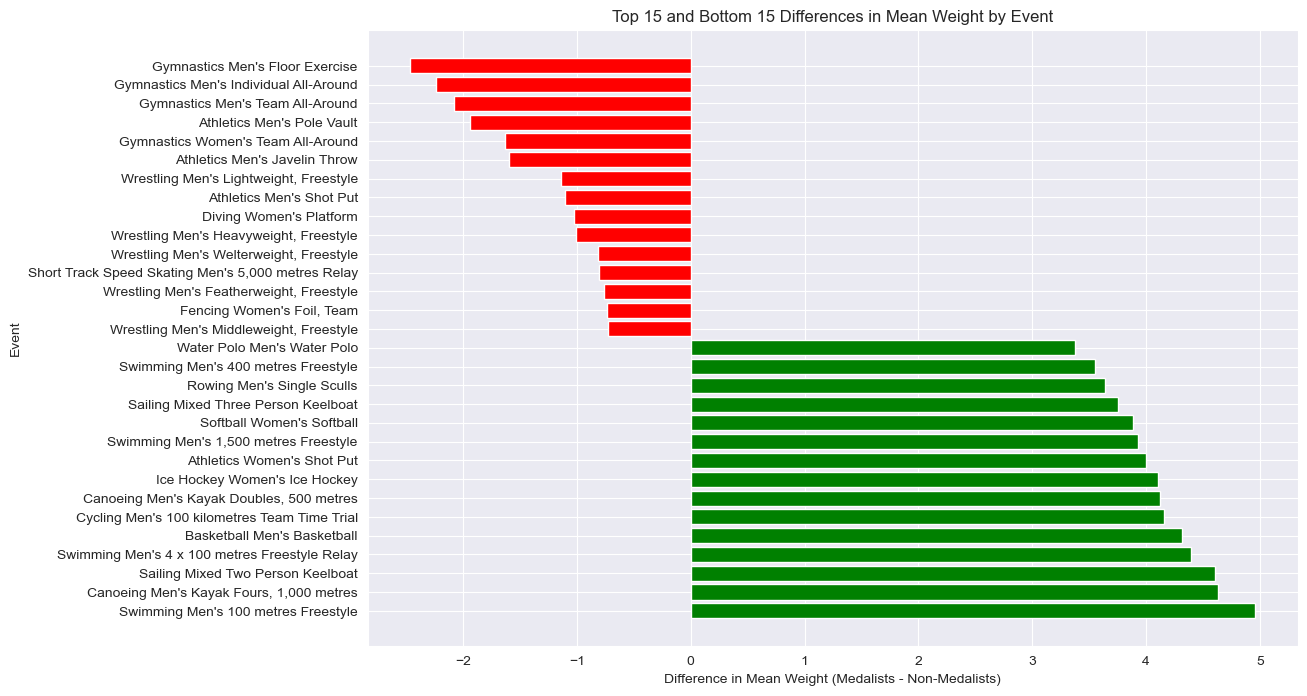

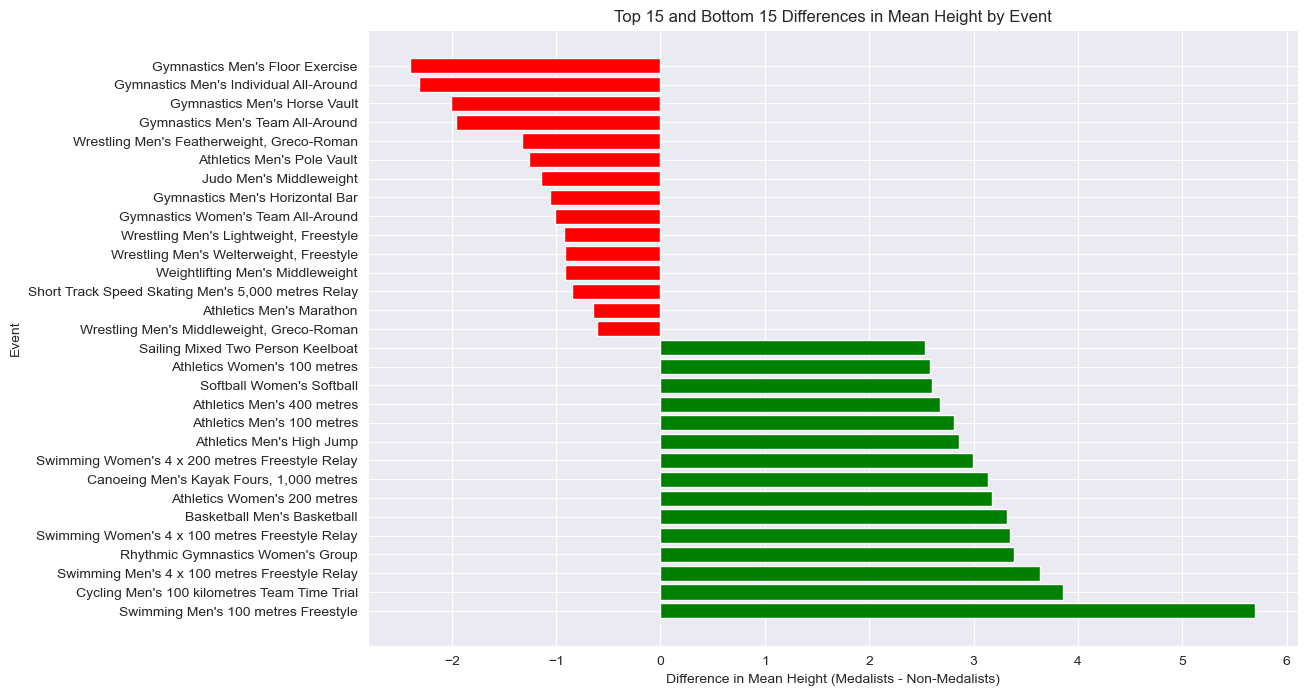

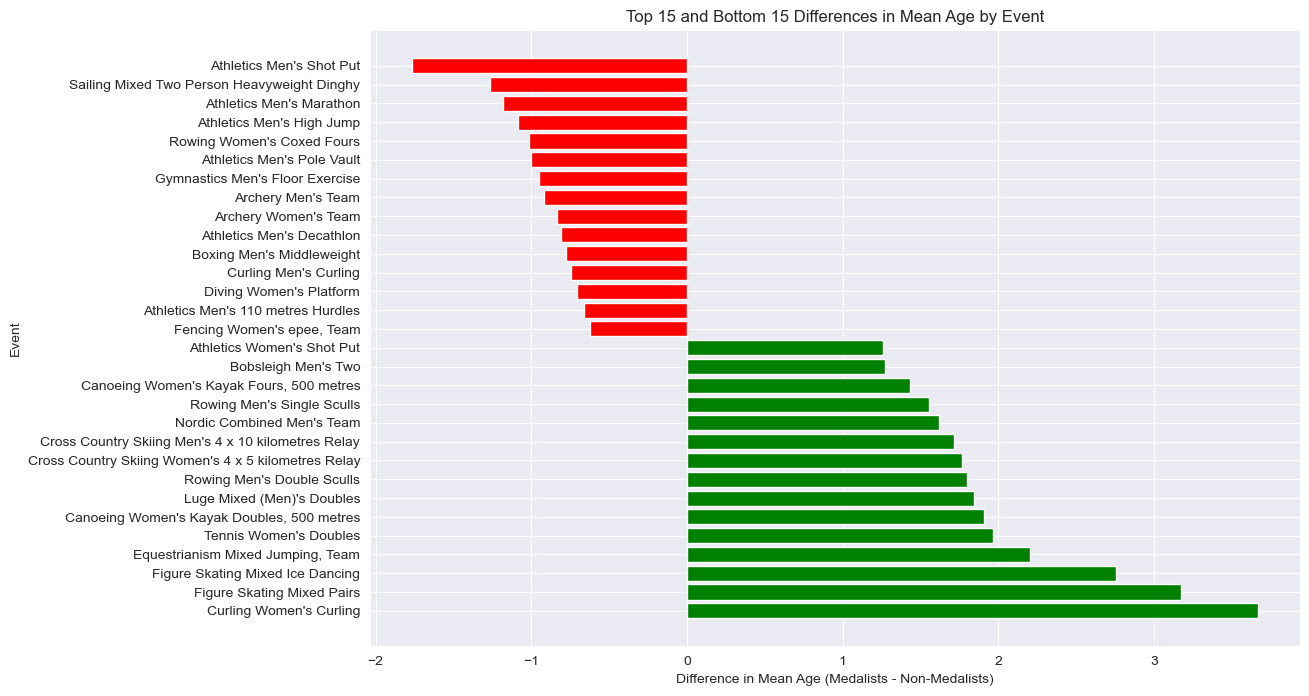

In [61]:
'''
Visualization of the Top and Bottom 10 Events for where Height and Weight's are factors in medaling
'''
merged_df = merged_df.sort_values(by="diff", ascending = True)
# Select the bottom 10 and top 10 differences
bottom_15 = merged_df.head(15)
top_15 = merged_df.tail(15)
# Concatenate the top and bottom 10 into a single DataFrame
combined_df = pd.concat([bottom_15, top_15])
combined_df = combined_df.sort_values(by="diff", ascending=False)
# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(combined_df.index, combined_df["diff"], color=['red' if x < 0 else 'green' for x in combined_df["diff"]])
# Add labels and title
plt.xlabel('Difference in Mean Weight (Medalists - Non-Medalists)')
plt.ylabel('Event')
plt.title('Top 15 and Bottom 15 Differences in Mean Weight by Event')
# Display the plot
plt.show()

### Now for Height
# Select the bottom 10 and top 10 differences
merged_df2 = merged_df2.sort_values(by="diff", ascending = True)
bottom2_15 = merged_df2.head(15)
top2_15 = merged_df2.tail(15)
# Concatenate the top and bottom 10 into a single DataFrame
combined_df2 = pd.concat([bottom2_15, top2_15])
combined_df2 = combined_df2.sort_values(by="diff", ascending=False)
# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(combined_df2.index, combined_df2["diff"], color=['red' if x < 0 else 'green' for x in combined_df2["diff"]])
# Add labels and title
plt.xlabel('Difference in Mean Height (Medalists - Non-Medalists)')
plt.ylabel('Event')
plt.title('Top 15 and Bottom 15 Differences in Mean Height by Event')
# Display the plot
plt.show()

### Now for Age
# Select the bottom 10 and top 10 differences
merged_df3 = merged_df3.sort_values(by="diff", ascending = True)
bottom3_15 = merged_df3.head(15)
top3_15 = merged_df3.tail(15)
# Concatenate the top and bottom 10 into a single DataFrame
combined_df3 = pd.concat([bottom3_15, top3_15])
combined_df3 = combined_df3.sort_values(by="diff", ascending=False)
# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(combined_df3.index, combined_df3["diff"], color=['red' if x < 0 else 'green' for x in combined_df3["diff"]])
# Add labels and title
plt.xlabel('Difference in Mean Age (Medalists - Non-Medalists)')
plt.ylabel('Event')
plt.title('Top 15 and Bottom 15 Differences in Mean Age by Event')
# Display the plot
plt.show()

As we can see in these figures, certain events such as gymnastics and wrestling usually have lighter and shorter medalists than non-medalists. While, the Swimming 100 meter freestyle, Cycling Men's 100km, Men's Basketball, etc. usually have taller and heavier medalists than non-medalists. It was also interesting to see the age as well. 

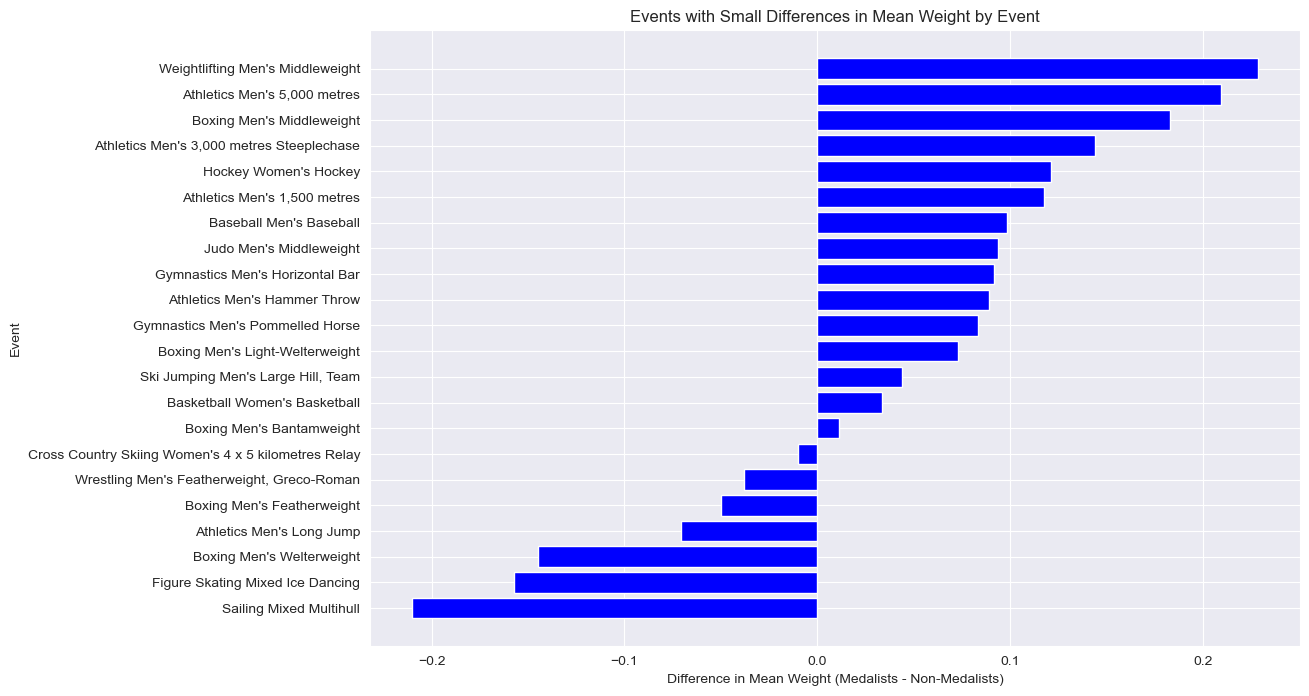

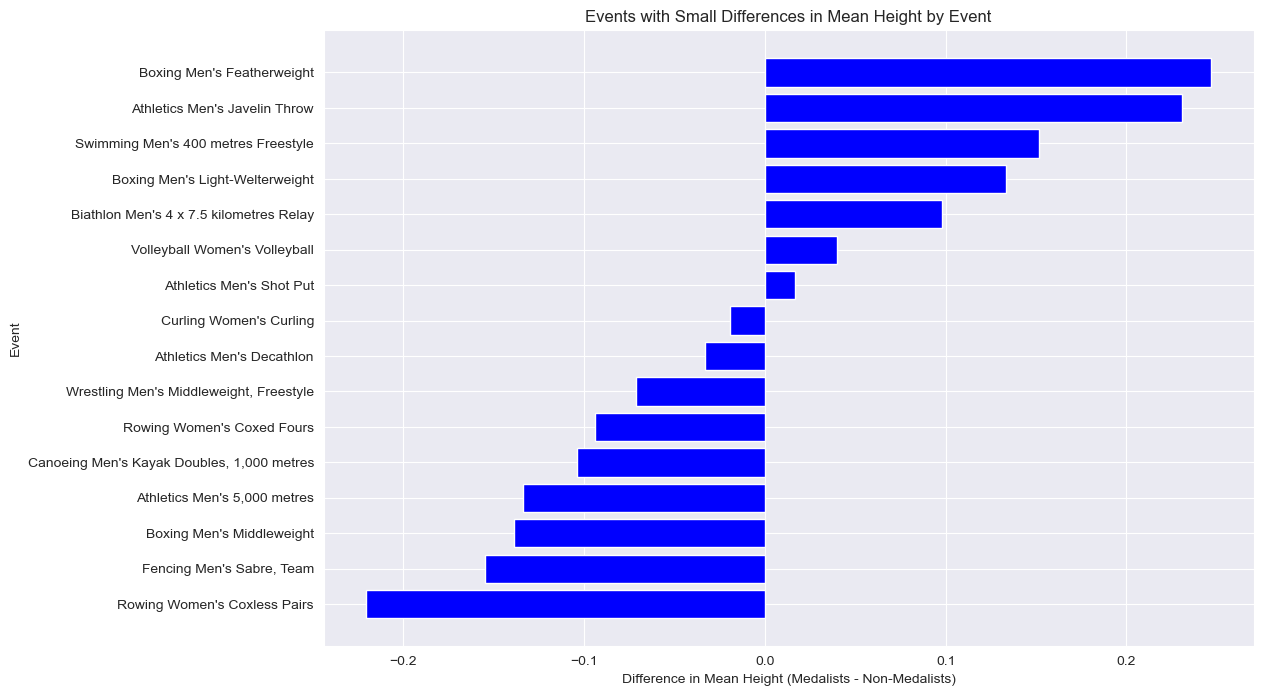

In [28]:
### Now for events where height and weight between medalists and non-medalists is not important
# Define a threshold for "close to zero"
threshold = .25  # Adjust this value as needed
# Filter events where the difference in weight is close to zero
close_to_zero_weight = merged_df[(merged_df["diff"].abs() <= threshold)]

# Plot the events where the difference in weight is close to zero
plt.figure(figsize=(12, 8))
plt.barh(close_to_zero_weight.index, close_to_zero_weight["diff"], color=['gray' if x == 0 else 'blue' for x in close_to_zero_weight["diff"]])
# Add labels and title
plt.xlabel('Difference in Mean Weight (Medalists - Non-Medalists)')
plt.ylabel('Event')
plt.title('Events with Small Differences in Mean Weight by Event')
plt.show()

# For Height, assuming merged_df2 contains the 'diff' column for height
# Filter events where the difference in height is close to zero
close_to_zero_height = merged_df2[(merged_df2["diff"].abs() <= threshold)]

# Plot the events where the difference in height is close to zero
plt.figure(figsize=(12, 8))
plt.barh(close_to_zero_height.index, close_to_zero_height["diff"], color=['gray' if x == 0 else 'blue' for x in close_to_zero_height["diff"]])
# Add labels and title
plt.xlabel('Difference in Mean Height (Medalists - Non-Medalists)')
plt.ylabel('Event')
plt.title('Events with Small Differences in Mean Height by Event')
plt.show()

### Creating the Models
For our models, we will have different use cases. We will test for seperately for events where Height/Weight is a factor, and for events where Height/Weight is not a factor. To do this we select the Swimming's Men's 100 metres Freestyle, and the Gymnastics Floor Exercise to test our models on data we already know is biased, and Boxing Men's Featherweight. Secondly, we will select from the middle of the dataframe to create a model that works best on an event where height/weight is not as important. Hopefully, with these methods we will be able to create space where we can accurately model different events. 

In [7]:
### The Swimming subset of the data
swimming_df = subset_enough_winners[subset_enough_winners['Event'] == "Swimming Men's 100 metres Freestyle"]
swimming_df.head()

Sex   Age  Height  Weight  NOC  Year     Sport  \
244     0  26.0   170.0    70.0  IRQ  2004  Swimming   
551     0  24.0   181.0    73.0  PHI  1968  Swimming   
751     0  20.0   180.0    74.0  SRI  2016  Swimming   
1022    0  19.0   177.0    64.0  POR  1980  Swimming   
1344    0  22.0   190.0    80.0  MRI  2008  Swimming   

                                    Event  Medal  
244   Swimming Men's 100 metres Freestyle      0  
551   Swimming Men's 100 metres Freestyle      0  
751   Swimming Men's 100 metres Freestyle      0  
1022  Swimming Men's 100 metres Freestyle      0  
1344  Swimming Men's 100 metres Freestyle      0

In [8]:
### The Gymnastics subset of the data
gymnastics_df = subset_enough_winners[subset_enough_winners['Event'] == "Gymnastics Men's Floor Exercise"]
gymnastics_df.describe()

Sex          Age       Height       Weight         Year        Medal
count  1376.0  1376.000000  1376.000000  1376.000000  1376.000000  1376.000000
mean      0.0    23.716570   167.587209    63.317587  1983.447674     0.037064
std       0.0     3.542928     5.347389     5.547495    18.695731     0.188987
min       0.0    16.000000   150.000000    46.000000  1932.000000     0.000000
25%       0.0    21.000000   164.000000    60.000000  1968.000000     0.000000
50%       0.0    23.000000   168.000000    63.500000  1984.000000     0.000000
75%       0.0    26.000000   171.000000    67.000000  2000.000000     0.000000
max       0.0    44.000000   185.000000    87.000000  2016.000000     1.000000

In [29]:
### Boxing subset
boxing_df = subset_enough_winners[subset_enough_winners['Event'] == "Boxing Men's Featherweight"]
boxing_df.describe()

Sex         Age      Height      Weight         Year       Medal
count  410.0  410.000000  410.000000  410.000000   410.000000  410.000000
mean     0.0   22.129268  168.717073   57.262195  1981.921951    0.139024
std      0.0    3.109316    5.144176    2.282100    16.829760    0.346395
min      0.0   16.000000  142.000000   50.000000  1920.000000    0.000000
25%      0.0   20.000000  165.000000   57.000000  1972.000000    0.000000
50%      0.0   22.000000  169.000000   57.000000  1984.000000    0.000000
75%      0.0   24.000000  172.000000   57.000000  1996.000000    0.000000
max      0.0   33.000000  190.000000   86.000000  2008.000000    1.000000

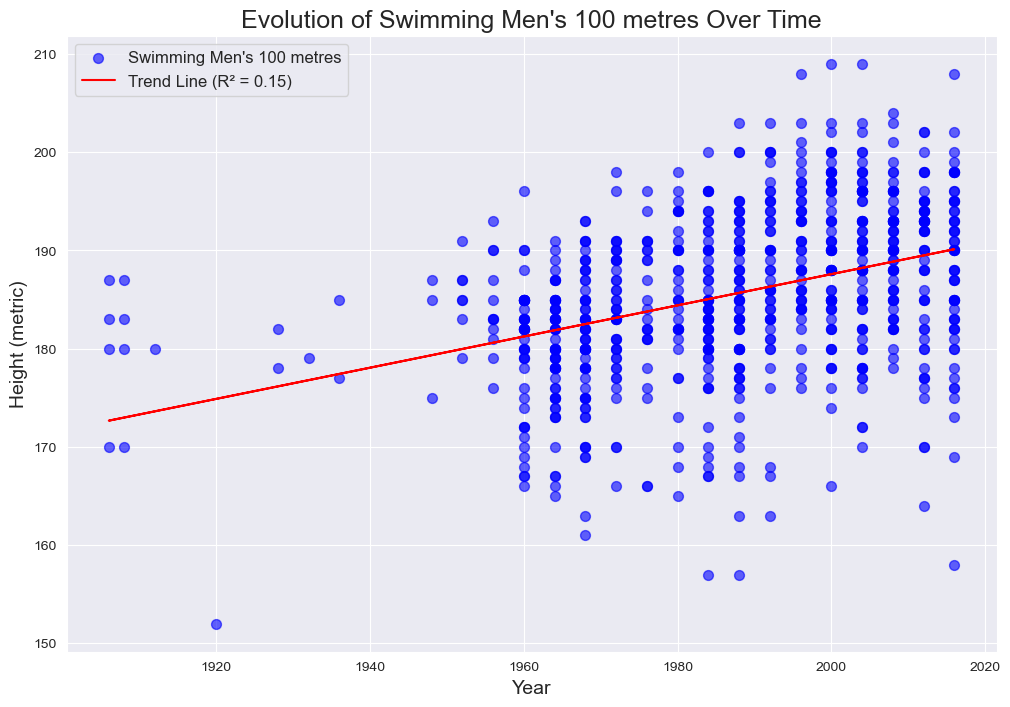

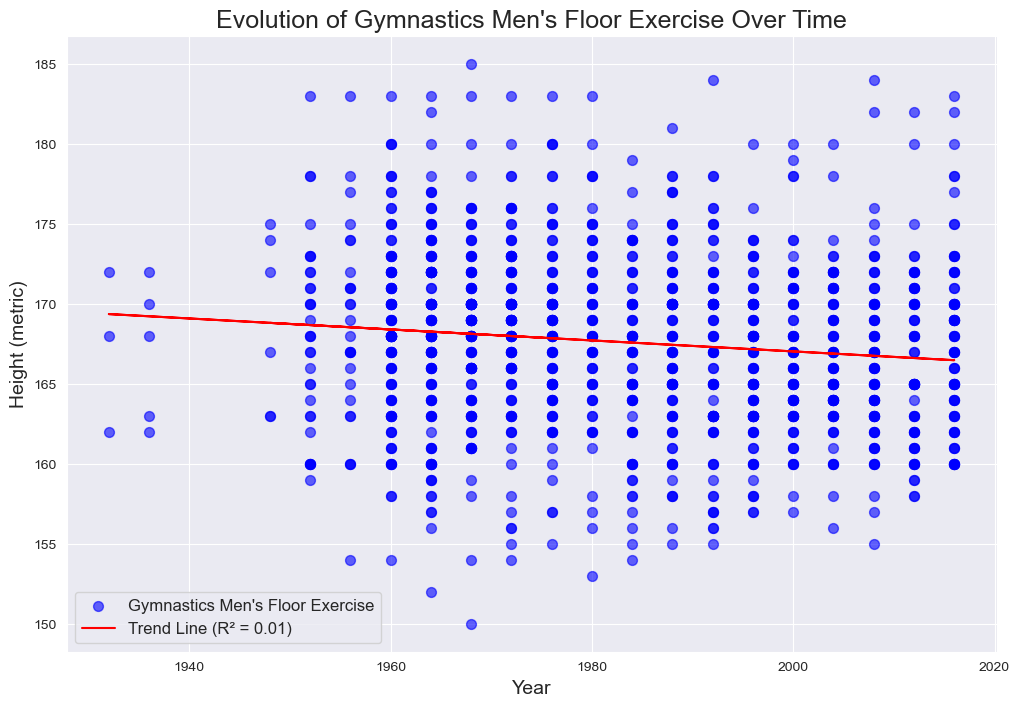

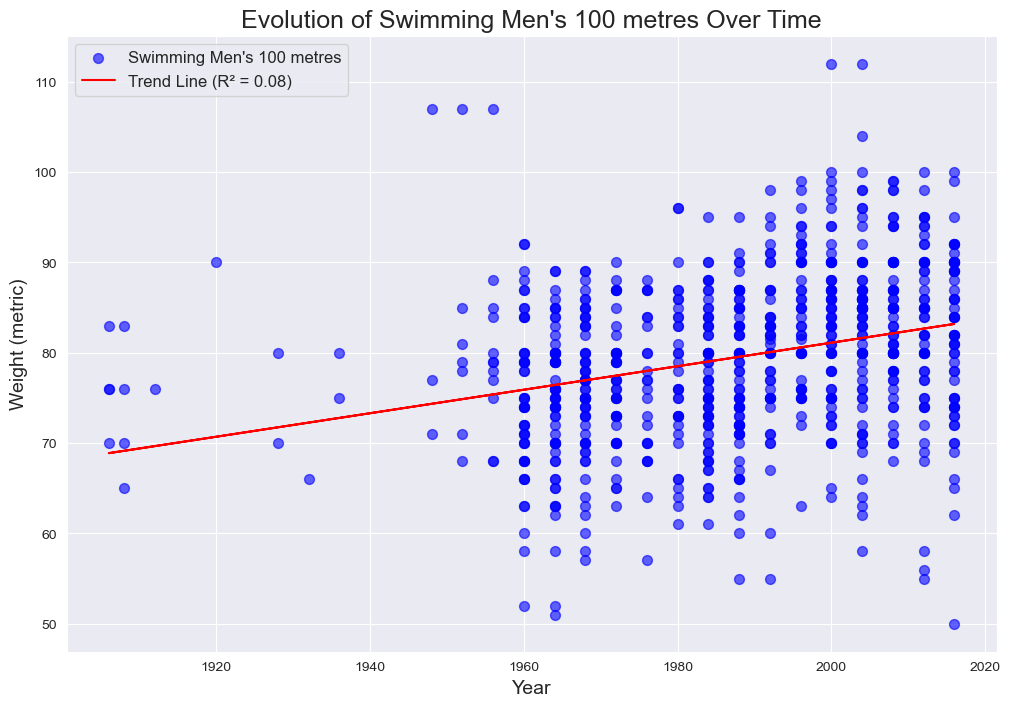

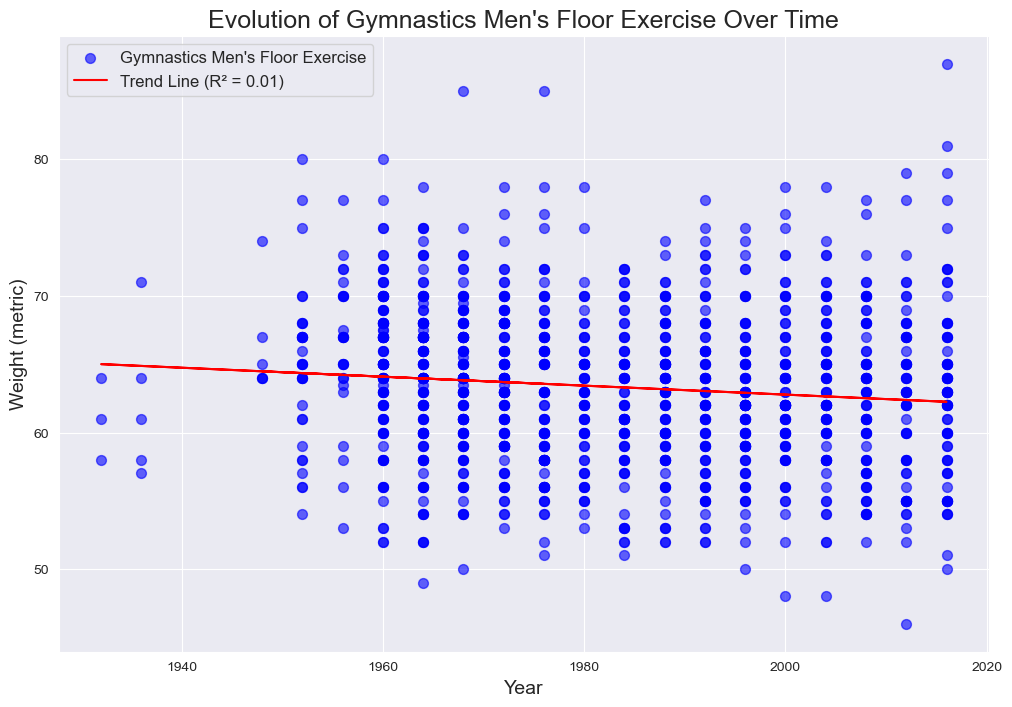

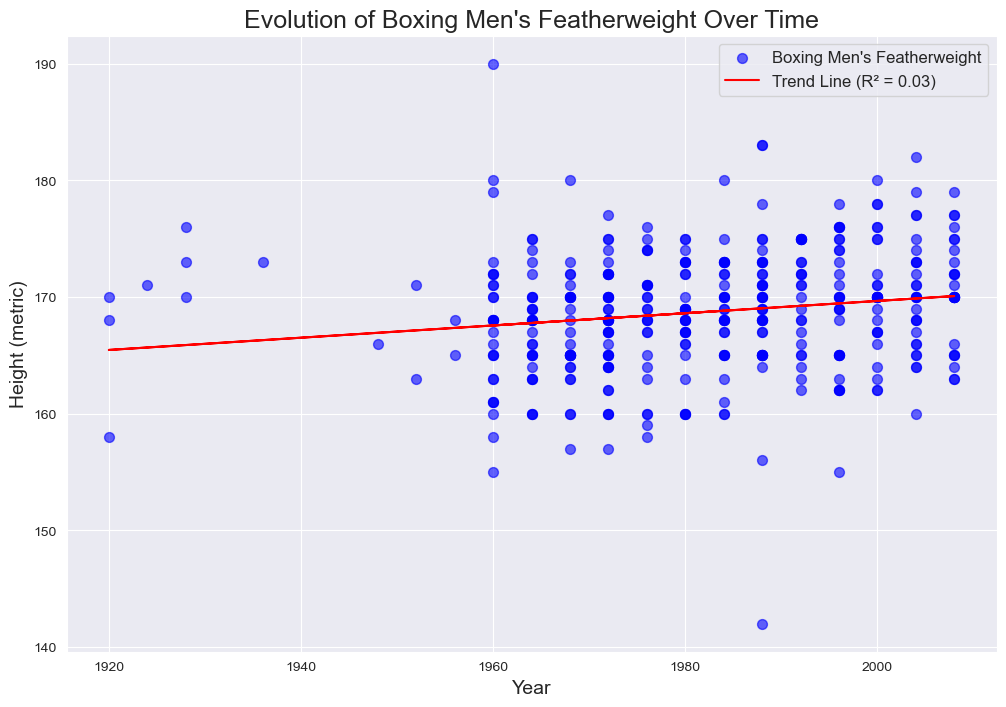

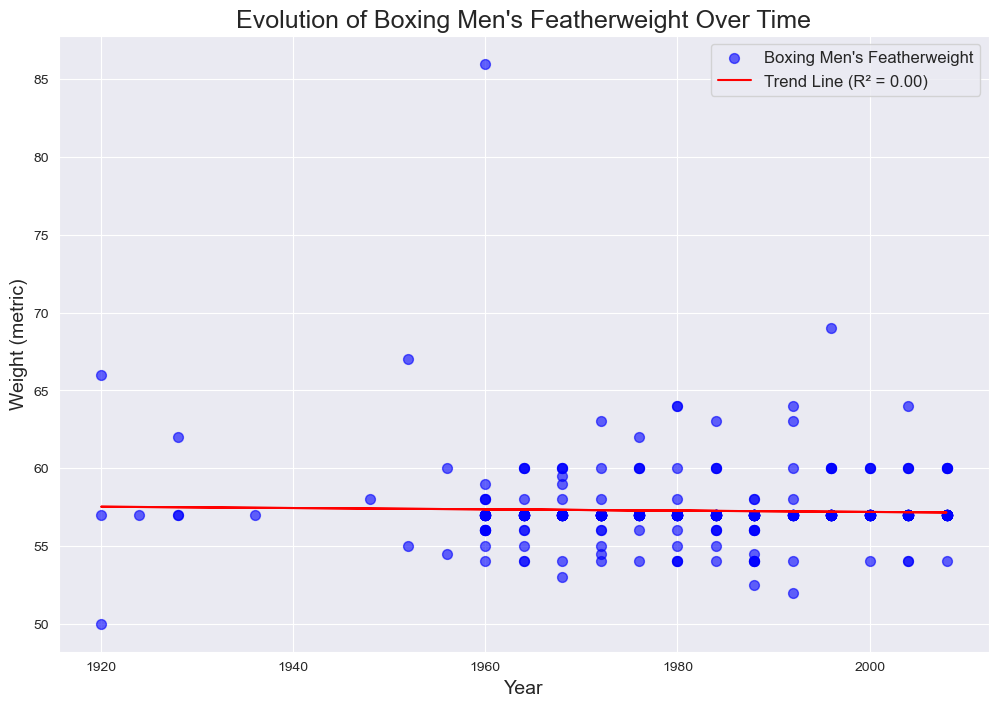

In [30]:
### It is interesting to check to see how these sports evolved over time to see Evolutionary Game Theory in action, so let's create a method to plot this
def plot_evolution(df, h_or_w, event_name):
    """
    Generates a plot showing the evolution of height over time.
    :param h_or_w: either height or weight
    :param df: DataFrame containing the data with columns "Year" and "Height".
    :param event_name: Name of the event.
    """
    plt.figure(figsize=(12, 8))
    
    # Scatter plot
    plt.scatter(df["Year"], df[h_or_w], label=event_name, color='blue', s=50, alpha=0.6)

    # Add a regression line
    slope, intercept, r_value, p_value, std_err = linregress(df["Year"], df[h_or_w])
    plt.plot(df["Year"], intercept + slope * df["Year"], 'r', label=f'Trend Line (R² = {r_value**2:.2f})')

    # Customize the plot
    plt.title(f"Evolution of {event_name} Over Time", fontsize=18)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel(f"{h_or_w} (metric)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.show()

plot_evolution(swimming_df,"Height", "Swimming Men's 100 metres")
plot_evolution(gymnastics_df,"Height", "Gymnastics Men's Floor Exercise")
plot_evolution(swimming_df,"Weight", "Swimming Men's 100 metres")
plot_evolution(gymnastics_df,"Weight", "Gymnastics Men's Floor Exercise")
plot_evolution(boxing_df,"Height", "Boxing Men's Featherweight")
plot_evolution(boxing_df,"Weight", "Boxing Men's Featherweight")

Positive slope and negative slope, shows it has been selected for in athletes at the olympics over time. (This is not even for just the medalists. Let's take a look at that real quick

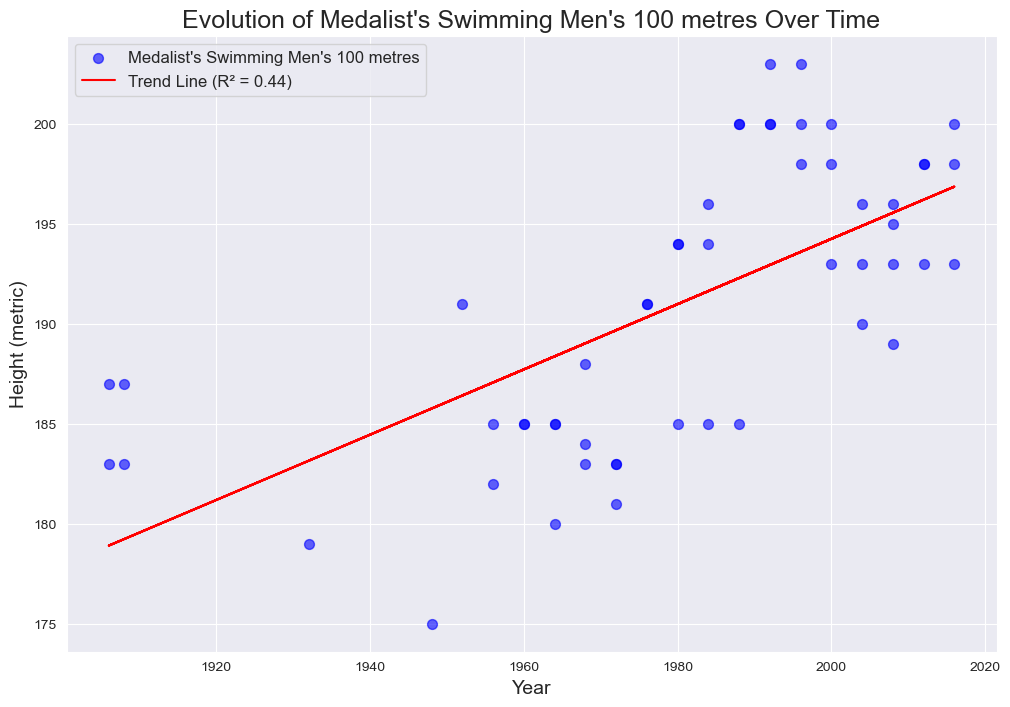

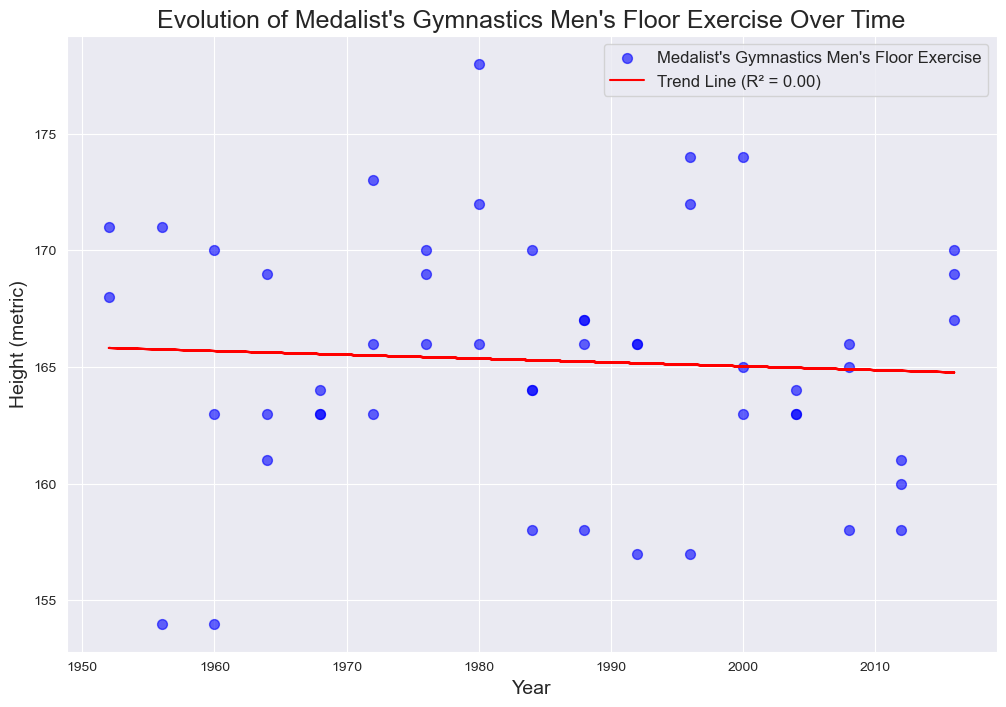

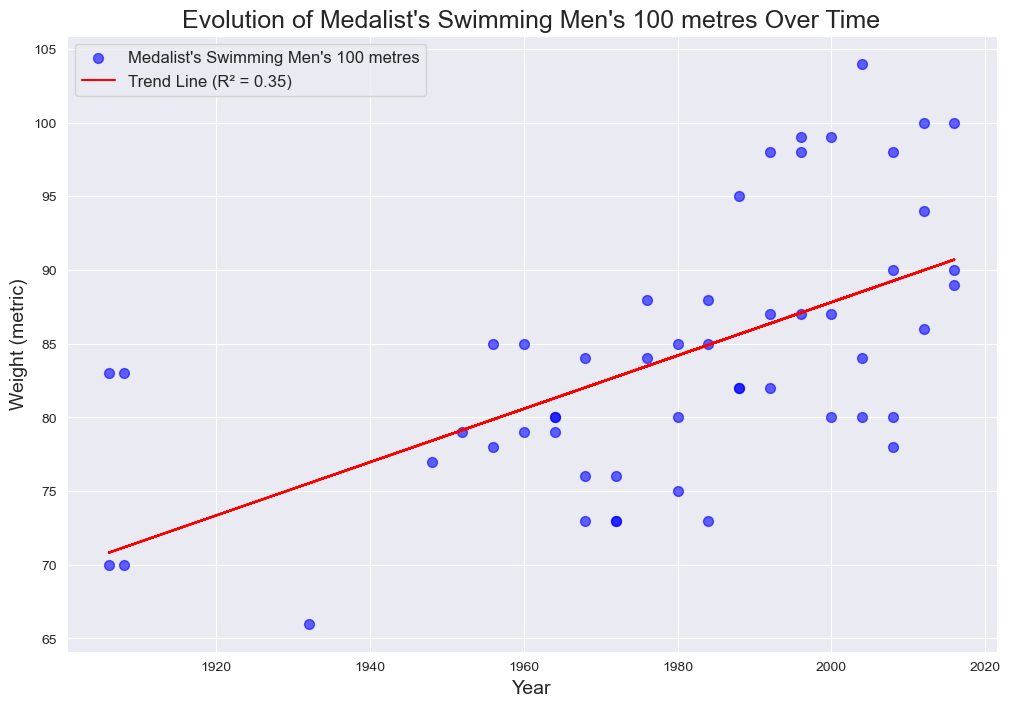

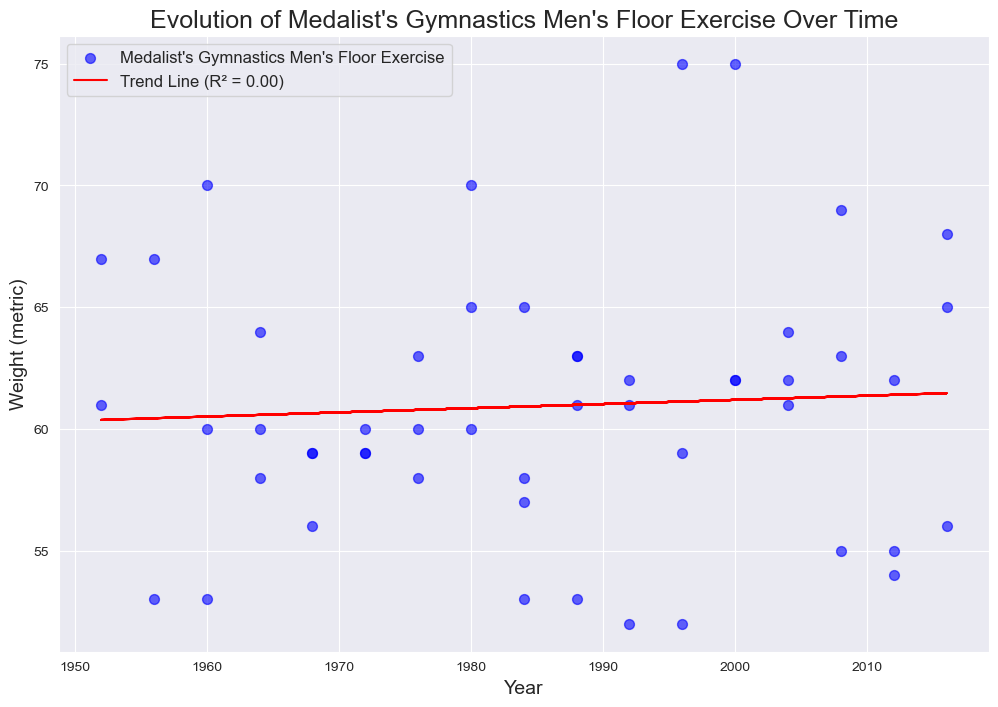

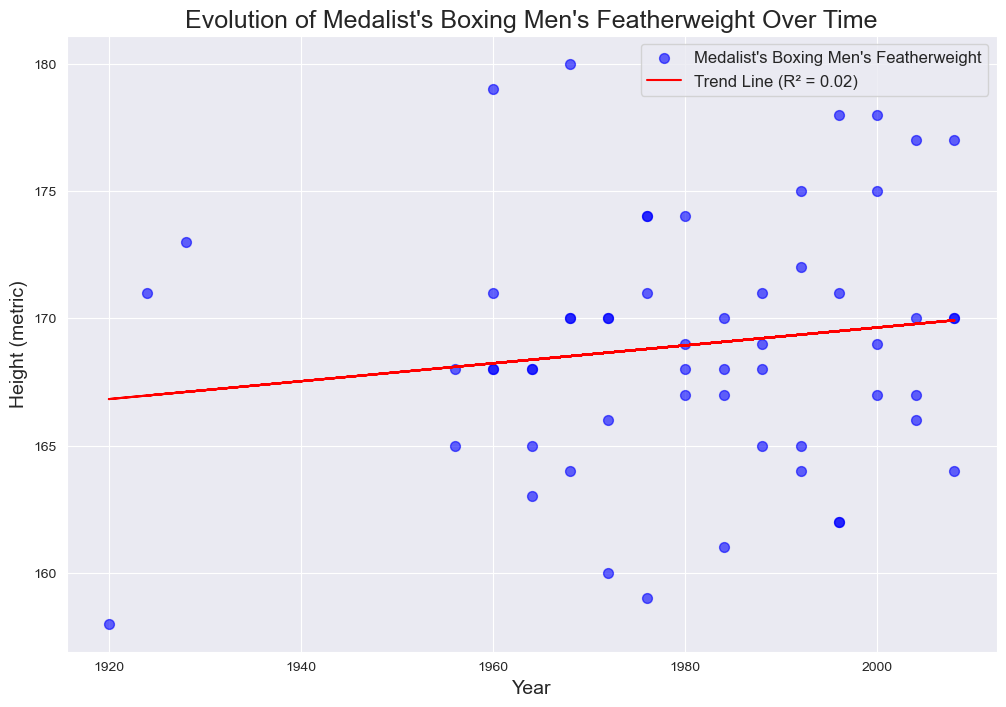

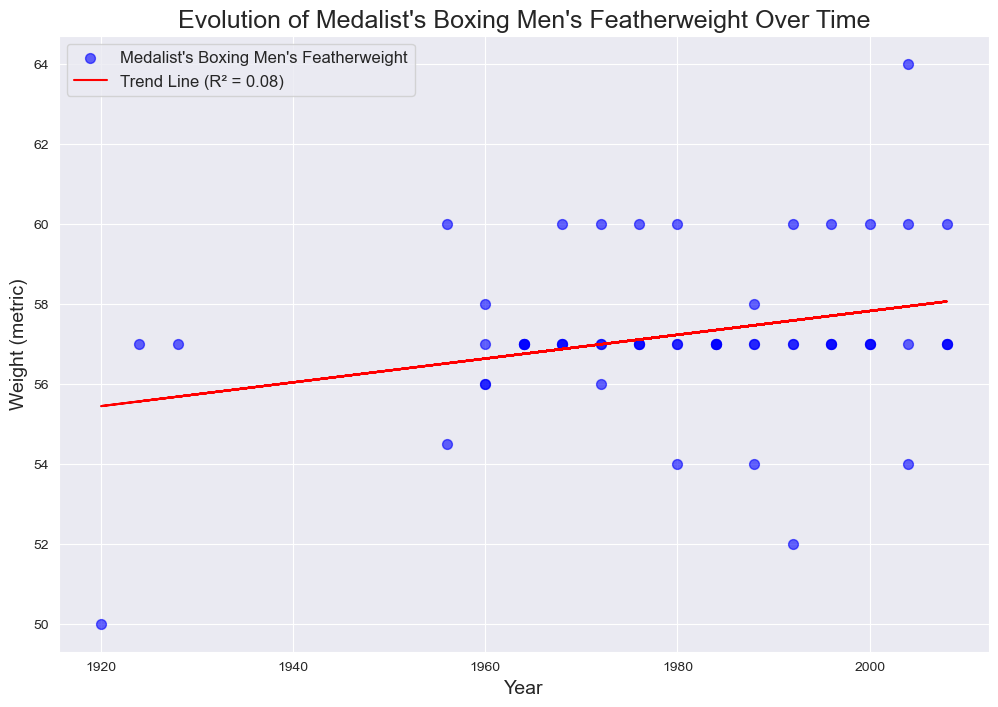

In [31]:
medal_swimming_df = swimming_df[swimming_df["Medal"]== 1]
medal_gymnastics_df = gymnastics_df[gymnastics_df["Medal"]== 1]
medal_boxing_df = boxing_df[boxing_df["Medal"]== 1]
plot_evolution(medal_swimming_df,"Height", "Medalist's Swimming Men's 100 metres")
plot_evolution(medal_gymnastics_df,"Height", "Medalist's Gymnastics Men's Floor Exercise")
plot_evolution(medal_swimming_df,"Weight", "Medalist's Swimming Men's 100 metres")
plot_evolution(medal_gymnastics_df,"Weight", "Medalist's Gymnastics Men's Floor Exercise")
plot_evolution(medal_boxing_df,"Height", "Medalist's Boxing Men's Featherweight")
plot_evolution(medal_boxing_df,"Weight", "Medalist's Boxing Men's Featherweight")

Far more correlated in swimming! While Gymnastics have been relatively steady over time (might be due to world's population getting slightly taller over time?) Same with Boxing

## Model time
### Below is Logistic Regression, excluding Geographic data for now

In [12]:
## Imports specific for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
'''
Here I created methods for each model so we can run them fairly quickly for different datasets
'''
def logistic_regression_model(df, feature_cols, target_col, test_size=0.3, random_state=42):
    """
    Training a Logistic Regression model
    :param df: DataFrame containing the data.
    :param feature_cols: List of column names to be used as features.
    :param target_col: Name of the target column.
    :param test_size: Proportion of data to be used for testing (default 0.3).
    :param random_state: Seed for train-test split (default 42).
    """
    # Splitting the data
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Equally weighting 0 and 1 
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    model = LogisticRegression(class_weight=dict(enumerate(class_weights)))
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Model evaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title("Logistic Regression - Confusion Matrix")
    plt.show()
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
    print(f"Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")
    # If the feature space is 2D, visualize decision boundary
    if X_train.shape[1] == 2:
        plot_decision_boundary(X_train, y_train, model, title=f"Logistic Regression - Decision Boundary for {df['Event'].values[0]}")

def plot_decision_boundary(X, y, model, title):
    """
    Plots the decision boundary for a binary classifier
    :param X: Features (must be 2D).
    :param y: Target values.
    :param model: Trained model.
    :param title: Title for the plot.
    """
    h = .02  # step size in the mesh

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

Accuracy: 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.59      0.73       234
           1       0.12      0.62      0.20        21

    accuracy                           0.60       255
   macro avg       0.53      0.61      0.47       255
weighted avg       0.88      0.60      0.69       255



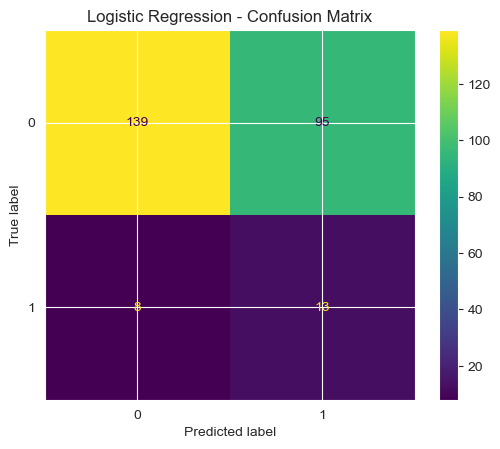

Cross-Validation Accuracy: 0.61 ± 0.05


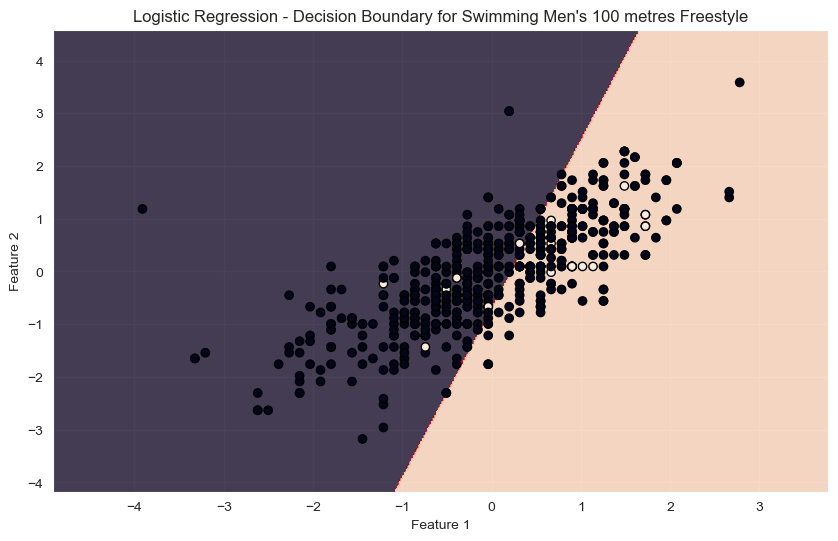

Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.62      0.76       399
           1       0.05      0.57      0.09        14

    accuracy                           0.62       413
   macro avg       0.51      0.60      0.43       413
weighted avg       0.94      0.62      0.74       413



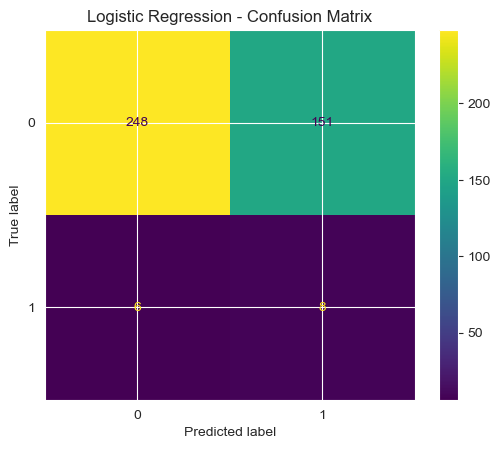

Cross-Validation Accuracy: 0.61 ± 0.03


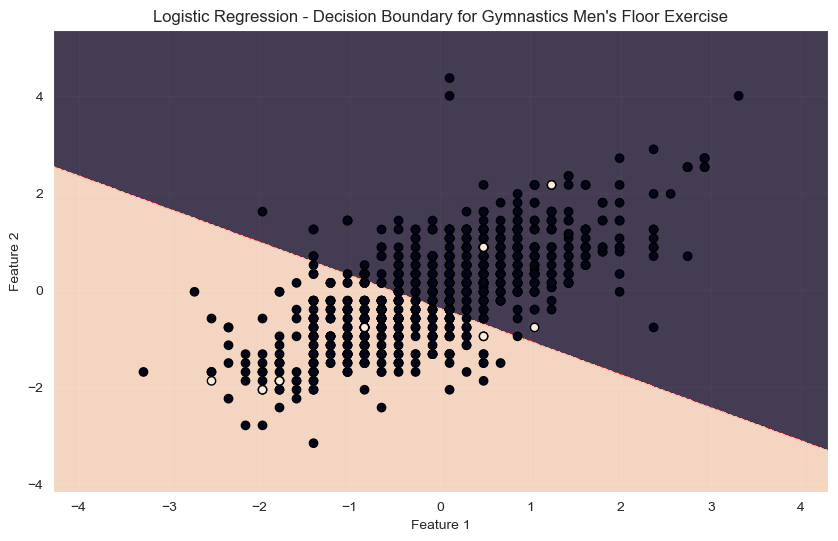

Accuracy: 0.63
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.62      0.75       109
           1       0.18      0.64      0.28        14

    accuracy                           0.63       123
   macro avg       0.56      0.63      0.51       123
weighted avg       0.85      0.63      0.69       123



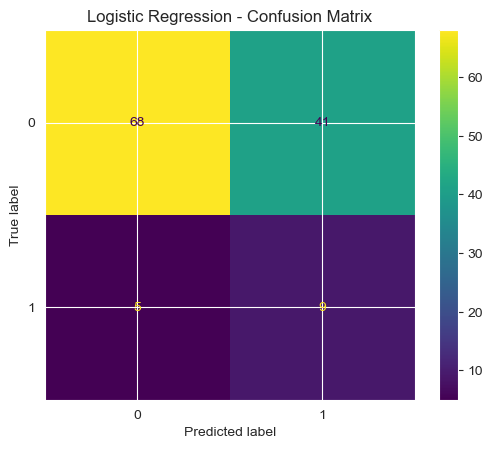

Cross-Validation Accuracy: 0.53 ± 0.10


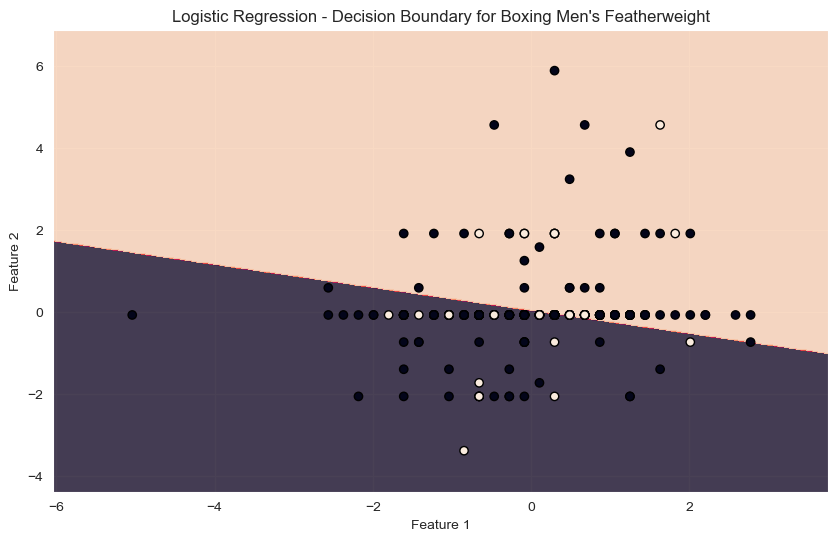

In [32]:
'''
Might need to Implement Reduce medals here
'''
### Let's call the logistic regression model for swimming
logistic_regression_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')
logistic_regression_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal')
logistic_regression_model(boxing_df, feature_cols=['Height', 'Weight'], target_col='Medal')

Can see that the model performs worse with Boxing due to not that much difference between medalists and non-medalist's attributes

### SVM Model excluding Geographic Data

In [14]:
### Now to try an SVM model
from sklearn.svm import SVC

def svm_model(df, feature_cols, target_col, test_size=0.3, random_state=42, kernel='linear'):
    """
    Trains an SVM model + visuals
    :param df: DataFrame containing the data, in this case the events
    :param feature_cols: List of column names to be used as features.
    :param target_col: Name of the target column.
    :param test_size: Proportion of data to be used for testing (default 0.3).
    :param random_state: Seed for train-test split (default 42).
    :param kernel: Kernel type for SVM (default 'linear').
    """
    # Splitting the data
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    # Creating and training the SVM model
    model = SVC(kernel=kernel, probability=True, class_weight='balanced')
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Model evaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"SVM ({kernel}) - Confusion Matrix")
    plt.show()

    # If the feature space is 2D, visualize decision boundary
    if X_train.shape[1] == 2:
        plot_decision_boundary(X_train, y_train, model, title=f"SVM ({kernel}) - Decision Boundary for {df['Event'].values[0]}")


Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.51      0.67       234
           1       0.12      0.76      0.21        21

    accuracy                           0.53       255
   macro avg       0.54      0.64      0.44       255
weighted avg       0.89      0.53      0.63       255



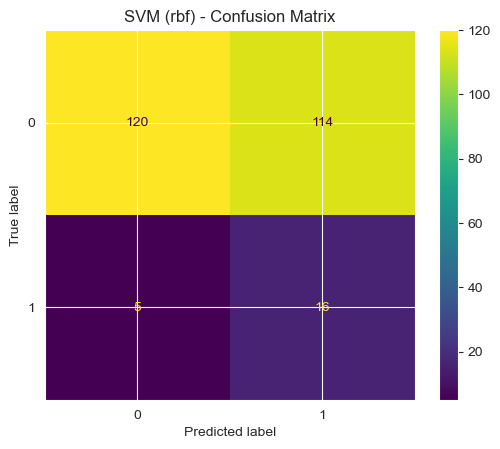

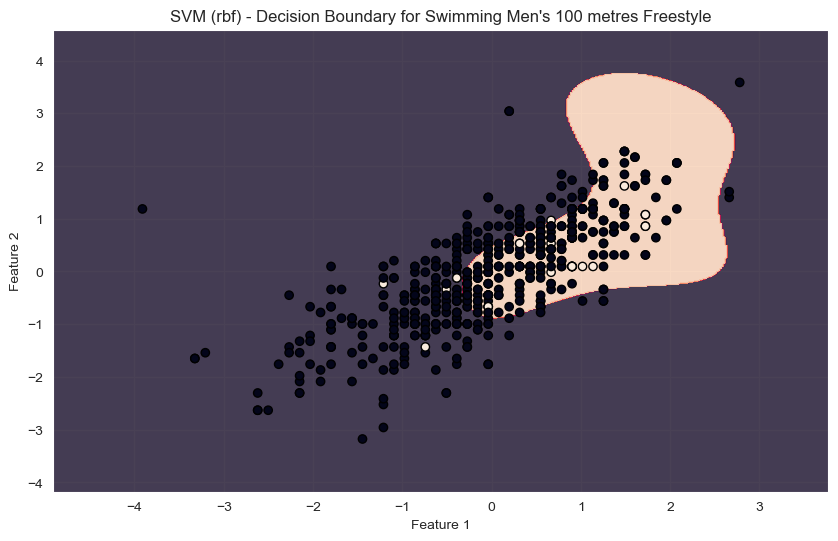

Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.58      0.73       399
           1       0.06      0.79      0.12        14

    accuracy                           0.59       413
   macro avg       0.52      0.68      0.42       413
weighted avg       0.96      0.59      0.71       413



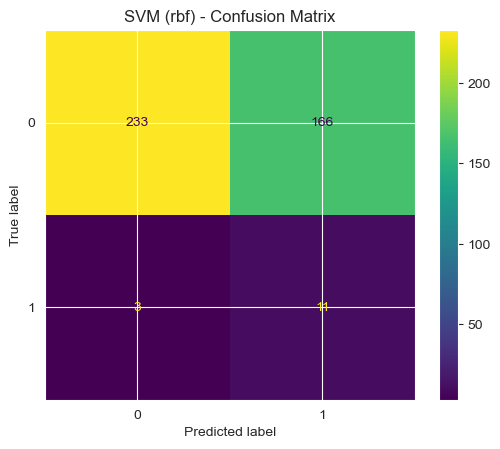

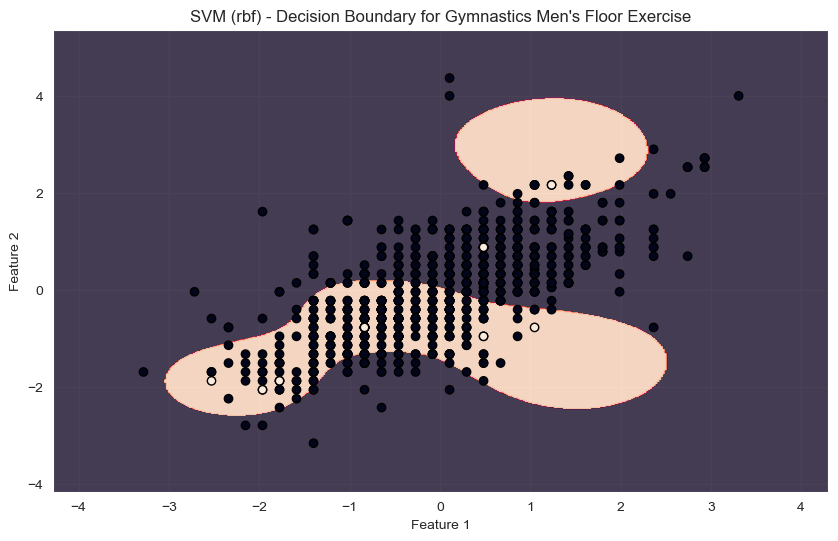

Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.76      0.82       109
           1       0.13      0.29      0.18        14

    accuracy                           0.71       123
   macro avg       0.51      0.52      0.50       123
weighted avg       0.81      0.71      0.75       123



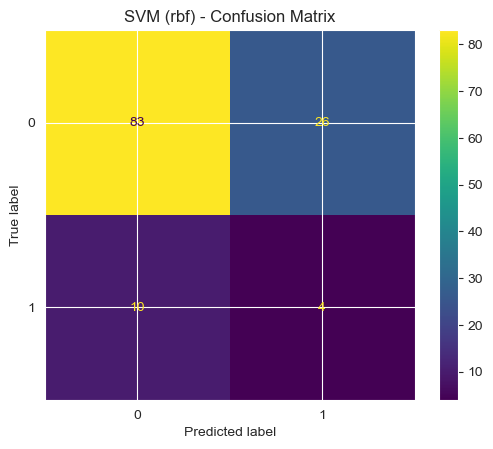

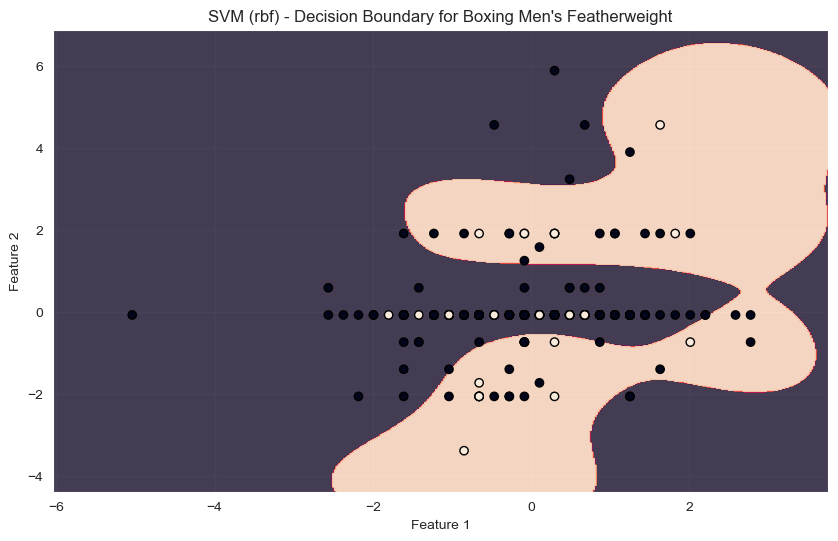

In [33]:
## Calling the SVM
svm_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal', kernel='rbf')
svm_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal', kernel='rbf')
svm_model(boxing_df, feature_cols=['Height', 'Weight'], target_col='Medal', kernel='rbf')

### Decision Tree

In [16]:
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, f1_score

def decision_tree_model(df, feature_cols, target_col):
    X = df[feature_cols]
    y = df[target_col]
    
    leaf_nodes = []
    scores = []

    # Test different numbers of leaf nodes
    for n_leaf_nodes in range(10, 201, 10):
        dtc_test = DecisionTreeClassifier(max_leaf_nodes=n_leaf_nodes, class_weight='balanced')
        dtc_test.fit(X, y)
        y_pred = dtc_test.predict(X)
        precision = precision_score(y, y_pred, pos_label=1)
        #add the scores into an array
        leaf_nodes.append(n_leaf_nodes)
        scores.append(precision)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(leaf_nodes, scores, marker='o')
    plt.xlabel('Number of Leaf Nodes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Leaf Nodes')
    plt.grid(True)
    plt.show()
    # Find the index of the maximum accuracy
    best_index = scores.index(max(scores))
    best_leaf_nodes = leaf_nodes[best_index]
    best_score = scores[best_index]
    print("Best Number of Leaf Nodes:", best_leaf_nodes)
    print("Best Precision Score:", best_score)
    # Model
    model = DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=best_leaf_nodes)
    model.fit(X, y)
    
    y_pred = model.predict(X)
    print("Decision Tree Classification Report:")
    print(classification_report(y, y_pred))
    
    class_names = list(map(str, model.classes_))
    # Plot decision tree
    plt.figure(figsize=(20,10))
    tree.plot_tree(model, feature_names=feature_cols, class_names=class_names, filled=True)
    plt.title("Decision Tree")
    plt.show()
    
    return model

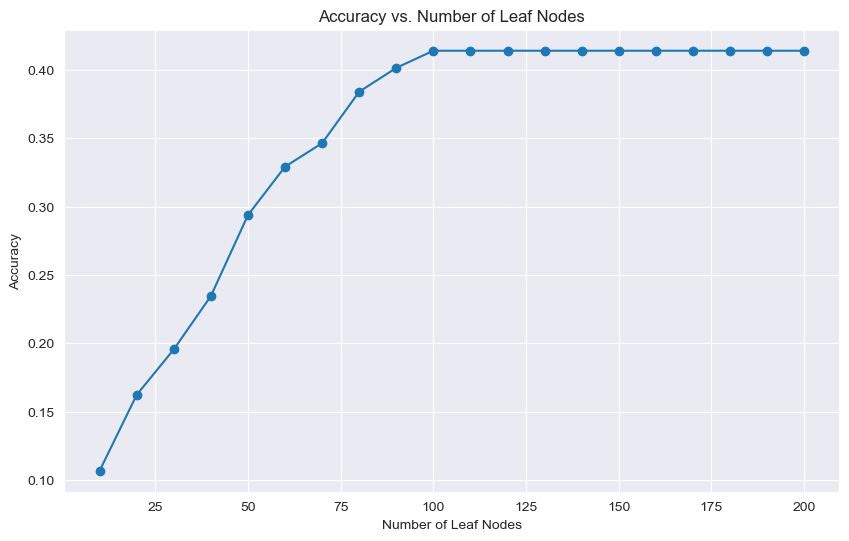

Best Number of Leaf Nodes: 100
Best Precision Score: 0.4140625
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       797
           1       0.41      1.00      0.59        53

    accuracy                           0.91       850
   macro avg       0.71      0.95      0.77       850
weighted avg       0.96      0.91      0.93       850



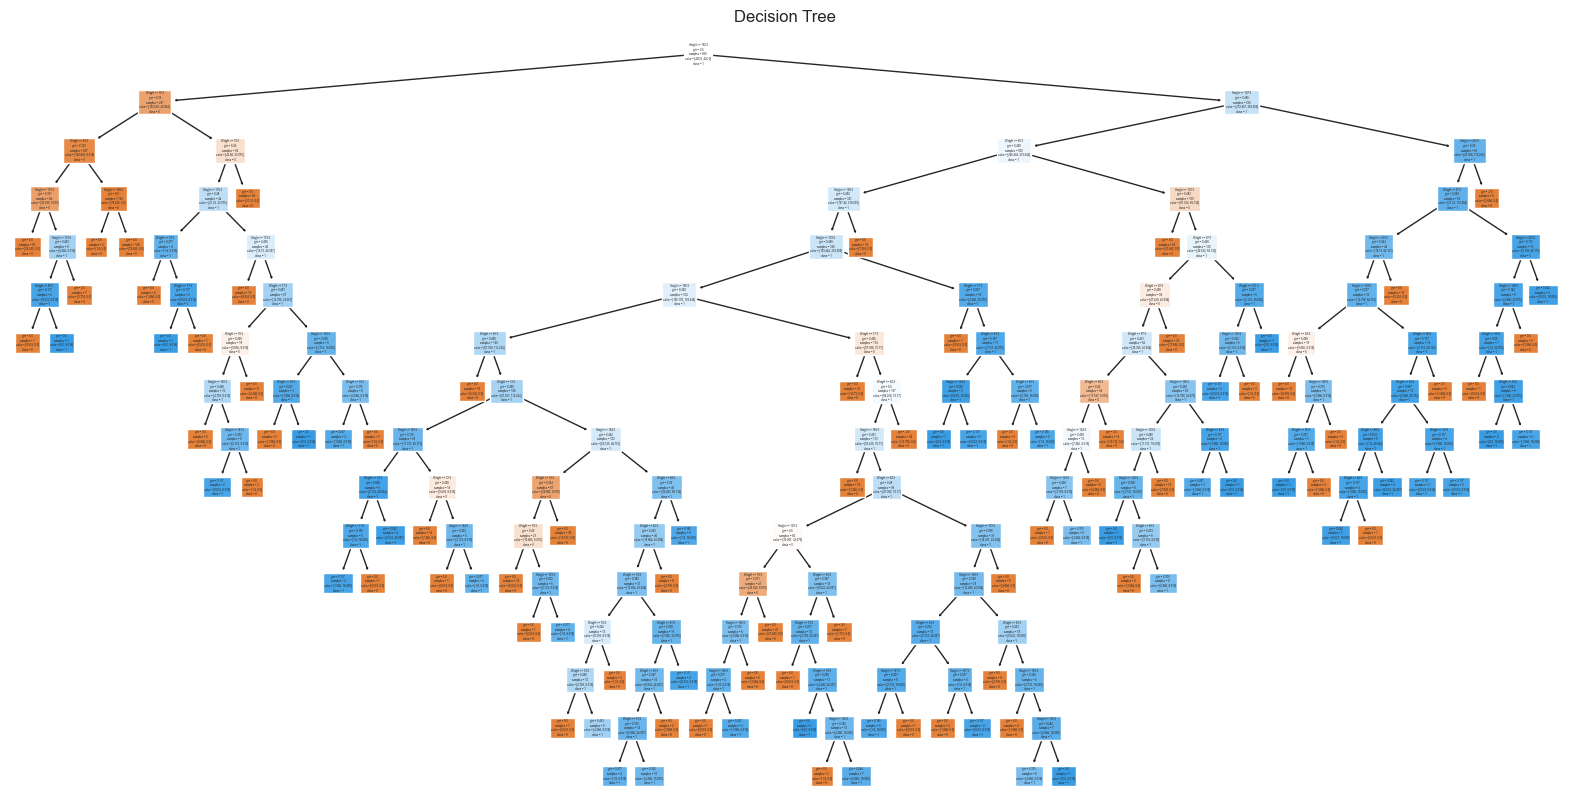

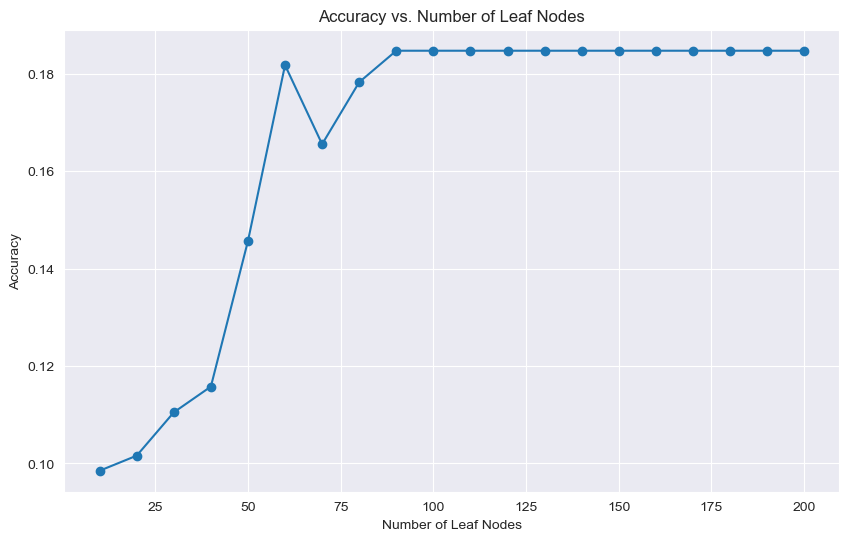

Best Number of Leaf Nodes: 90
Best Precision Score: 0.18478260869565216
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1325
           1       0.18      1.00      0.31        51

    accuracy                           0.84      1376
   macro avg       0.59      0.92      0.61      1376
weighted avg       0.97      0.84      0.89      1376



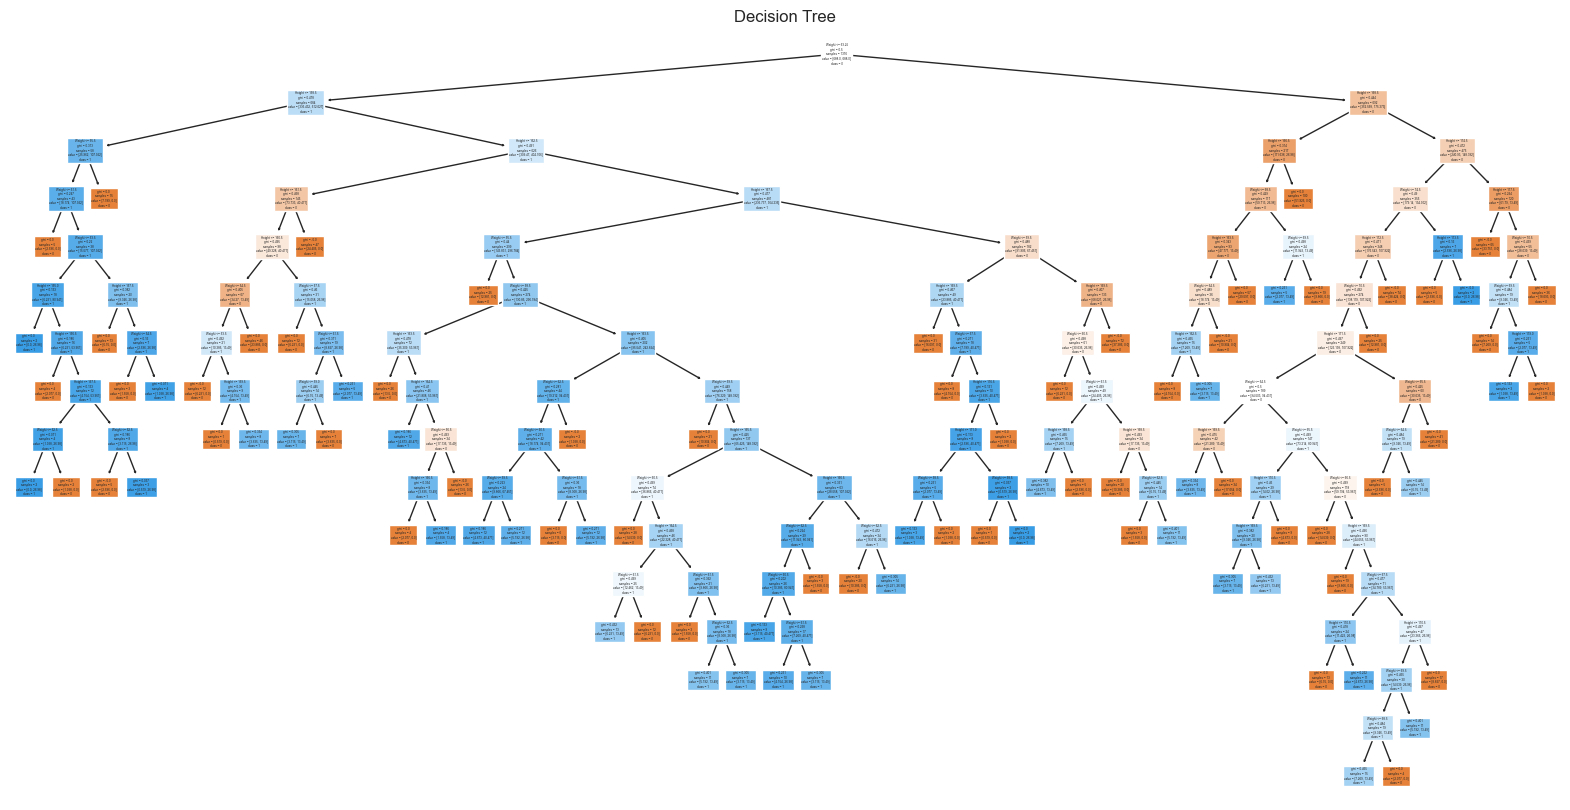

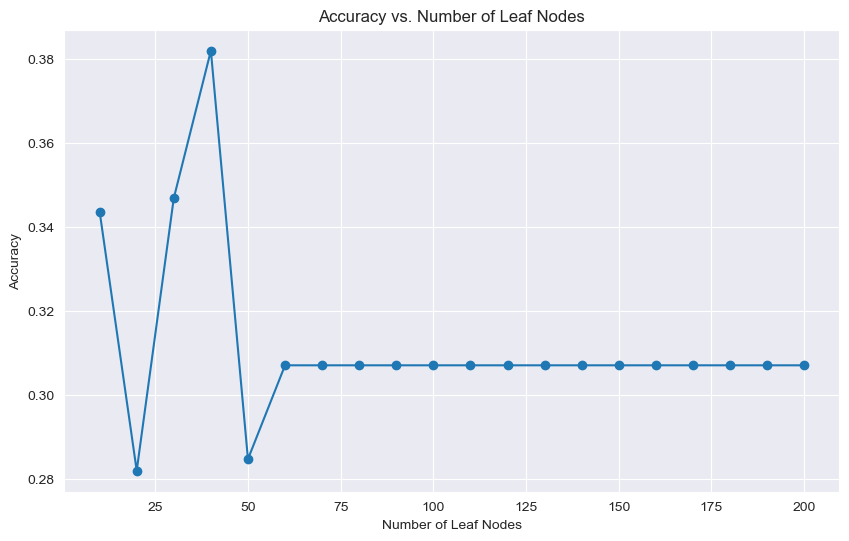

Best Number of Leaf Nodes: 40
Best Precision Score: 0.38202247191011235
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       353
           1       0.38      0.60      0.47        57

    accuracy                           0.81       410
   macro avg       0.66      0.72      0.68       410
weighted avg       0.85      0.81      0.83       410



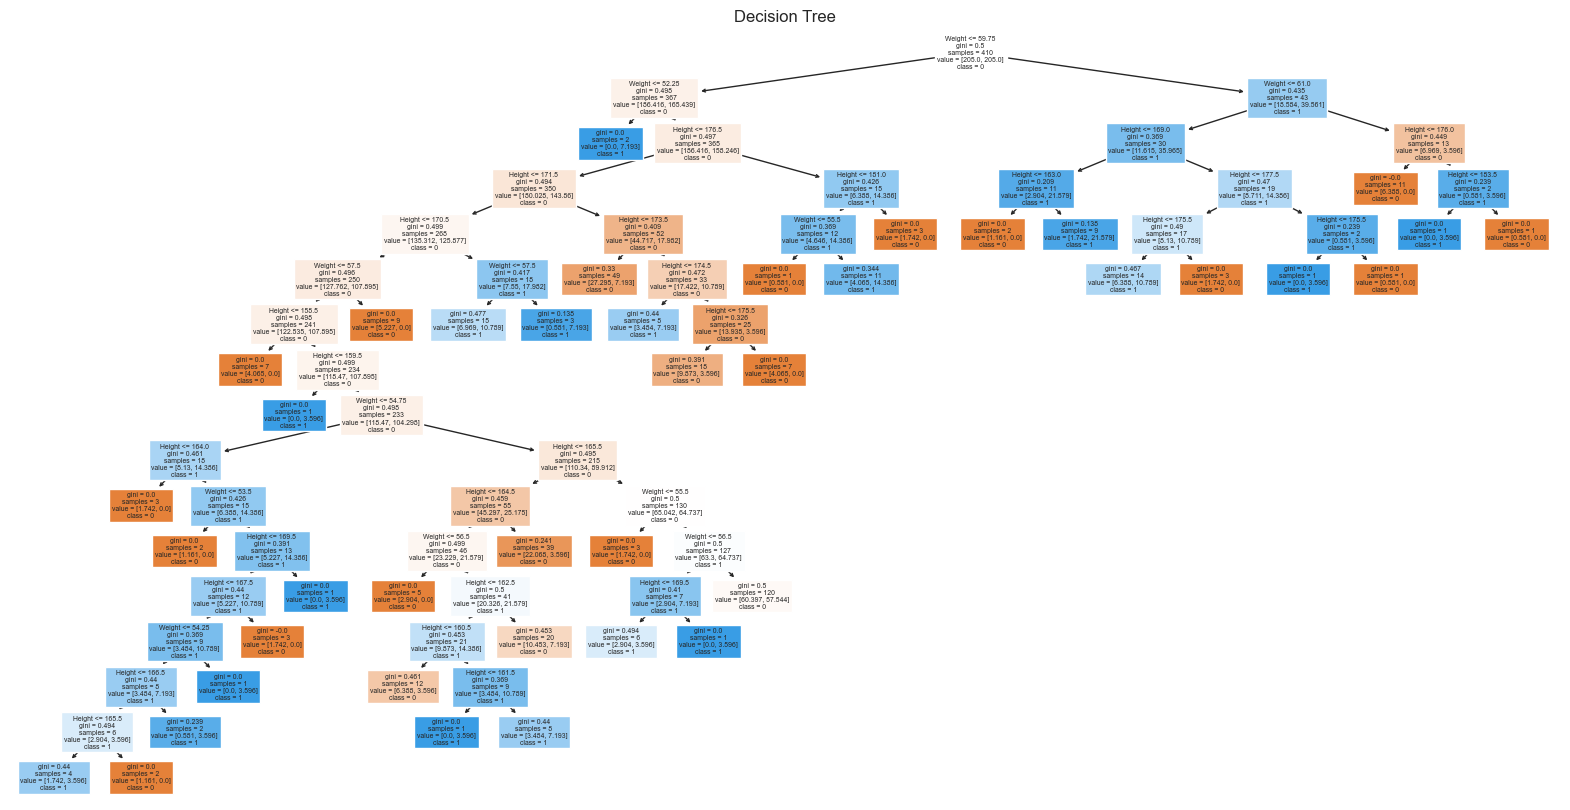

In [34]:
dtc = decision_tree_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')
dtc2 = decision_tree_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal')
dtc3 = decision_tree_model(boxing_df, feature_cols=['Height', 'Weight'], target_col='Medal')

In [35]:
print("Decision tree for Swimming")
print(export_text(dtc))
print("Decision tree for Gymnastics")
print(export_text(dtc2))
print("Decision tree for Boxing")
print(export_text(dtc3))

Decision tree for Swimming
|--- feature_0 <= 182.50
|   |--- feature_1 <= 75.50
|   |   |--- feature_1 <= 66.50
|   |   |   |--- feature_0 <= 178.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  178.50
|   |   |   |   |--- feature_0 <= 179.50
|   |   |   |   |   |--- feature_1 <= 65.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_1 >  65.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_0 >  179.50
|   |   |   |   |   |--- class: 0
|   |   |--- feature_1 >  66.50
|   |   |   |--- feature_0 <= 166.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  166.50
|   |   |   |   |--- class: 0
|   |--- feature_1 >  75.50
|   |   |--- feature_1 <= 79.50
|   |   |   |--- feature_0 <= 175.50
|   |   |   |   |--- feature_1 <= 76.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  76.50
|   |   |   |   |   |--- feature_1 <= 77.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_1 >  77.50
|

### Bagging

In [39]:
def bagging_model(df, feature_cols, target_col, est):    ## Bagging model method
    X = df[feature_cols]
    y = df[target_col]
    
    model = BaggingClassifier(estimator=est)
    model.fit(X, y)
    
    y_pred = model.predict(X)
    print("Bagging Classification Report:")
    print(classification_report(y, y_pred))
    
    return model

In [40]:
bagging_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal', est=dtc)
bagging_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal',est= dtc2)
bagging_model(boxing_df, feature_cols=['Height', 'Weight'], target_col='Medal',est= dtc3)

Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       797
           1       0.47      0.85      0.61        53

    accuracy                           0.93       850
   macro avg       0.73      0.89      0.79       850
weighted avg       0.96      0.93      0.94       850

Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1325
           1       0.23      0.82      0.36        51

    accuracy                           0.89      1376
   macro avg       0.61      0.86      0.65      1376
weighted avg       0.96      0.89      0.92      1376

Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       353
           1       0.35      0.58      0.44        57

    accuracy                           0.79       410
   macro avg       0.64      0.70  

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_leaf_nodes=40))

### Boosting

In [21]:
def boosting_model(df, feature_cols, target_col):
    X = df[feature_cols]
    y = df[target_col]
    
    model = GradientBoostingClassifier()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    print("Boosting Classification Report:")
    print(classification_report(y, y_pred))
    
    return model

In [37]:
boosting_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')
boosting_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal')
boosting_model(boxing_df, feature_cols=['Height', 'Weight'], target_col='Medal')

Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       797
           1       0.74      0.26      0.39        53

    accuracy                           0.95       850
   macro avg       0.84      0.63      0.68       850
weighted avg       0.94      0.95      0.94       850

Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1325
           1       1.00      0.16      0.27        51

    accuracy                           0.97      1376
   macro avg       0.98      0.58      0.63      1376
weighted avg       0.97      0.97      0.96      1376

Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       353
           1       0.87      0.23      0.36        57

    accuracy                           0.89       410
   macro avg       0.88      0.6

GradientBoostingClassifier()

### Random Forest

In [23]:
def random_forest_model(df, feature_cols, target_col):
    X = df[feature_cols]
    y = df[target_col]
    
    model = RandomForestClassifier()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    print("Random Forest Classification Report:")
    print(classification_report(y, y_pred))
    
    # Feature importances plot
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), np.array(feature_cols)[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
    return model

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       797
           1       0.78      0.47      0.59        53

    accuracy                           0.96       850
   macro avg       0.87      0.73      0.78       850
weighted avg       0.95      0.96      0.95       850



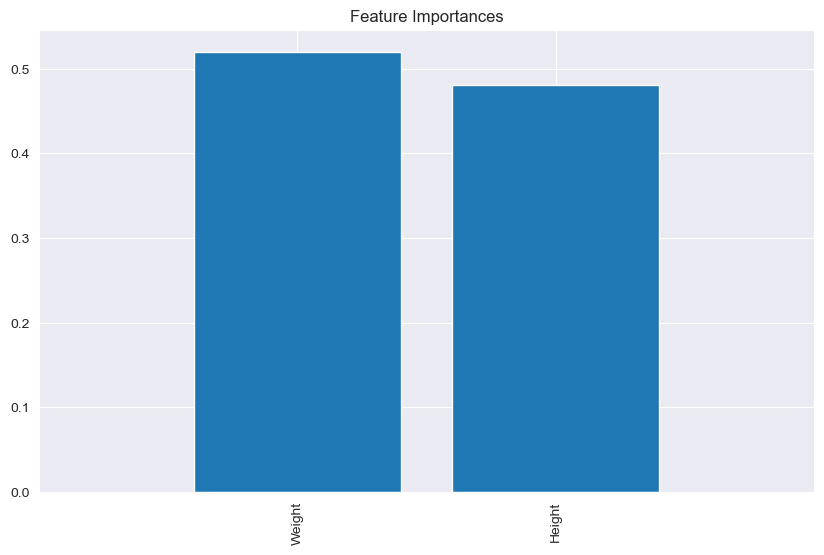

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1325
           1       0.80      0.24      0.36        51

    accuracy                           0.97      1376
   macro avg       0.89      0.62      0.67      1376
weighted avg       0.96      0.97      0.96      1376



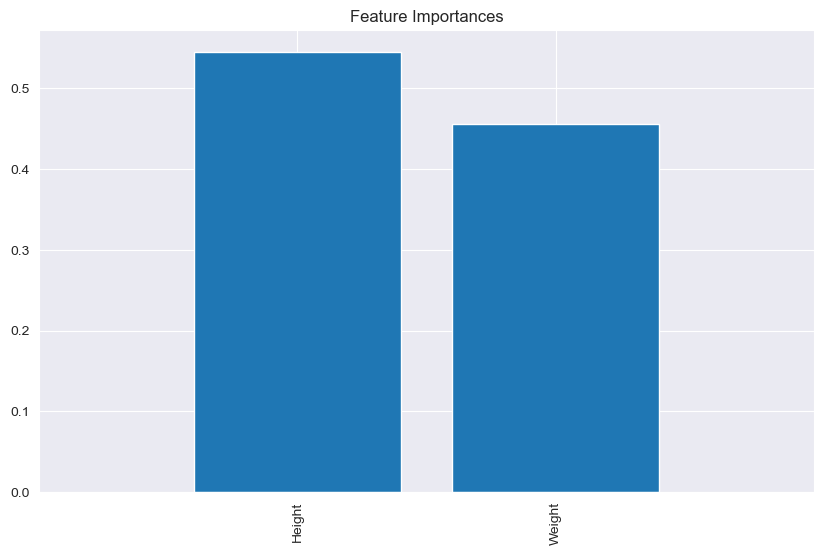

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       353
           1       0.85      0.30      0.44        57

    accuracy                           0.90       410
   macro avg       0.87      0.64      0.69       410
weighted avg       0.89      0.90      0.87       410



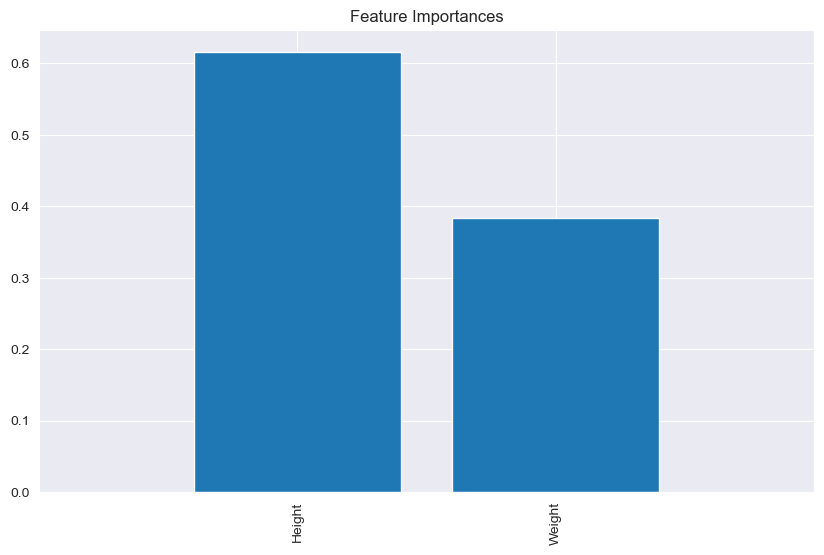

RandomForestClassifier()

In [41]:
random_forest_model(swimming_df, feature_cols=['Height', 'Weight'], target_col='Medal')
random_forest_model(gymnastics_df, feature_cols=['Height', 'Weight'], target_col='Medal')
random_forest_model(boxing_df, feature_cols=['Height', 'Weight'], target_col='Medal')

### Random Forest with Age

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       797
           1       1.00      0.87      0.93        53

    accuracy                           0.99       850
   macro avg       1.00      0.93      0.96       850
weighted avg       0.99      0.99      0.99       850



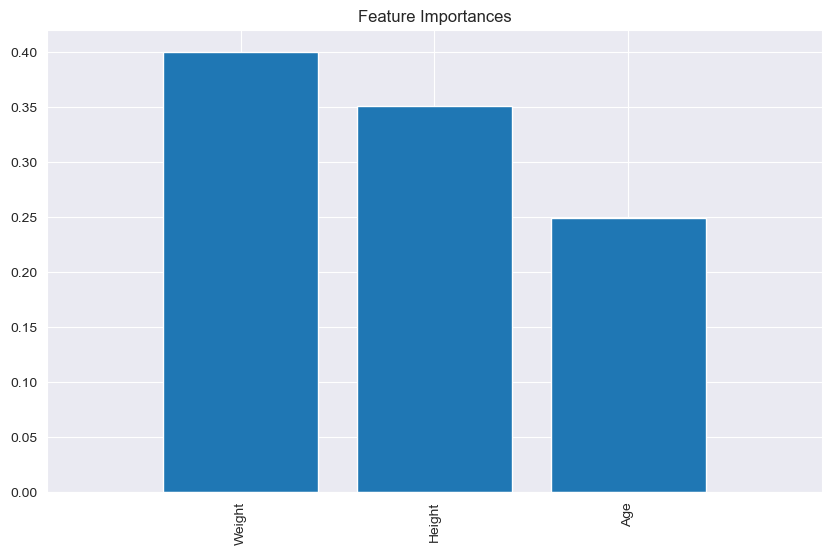

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1325
           1       1.00      0.67      0.80        51

    accuracy                           0.99      1376
   macro avg       0.99      0.83      0.90      1376
weighted avg       0.99      0.99      0.99      1376



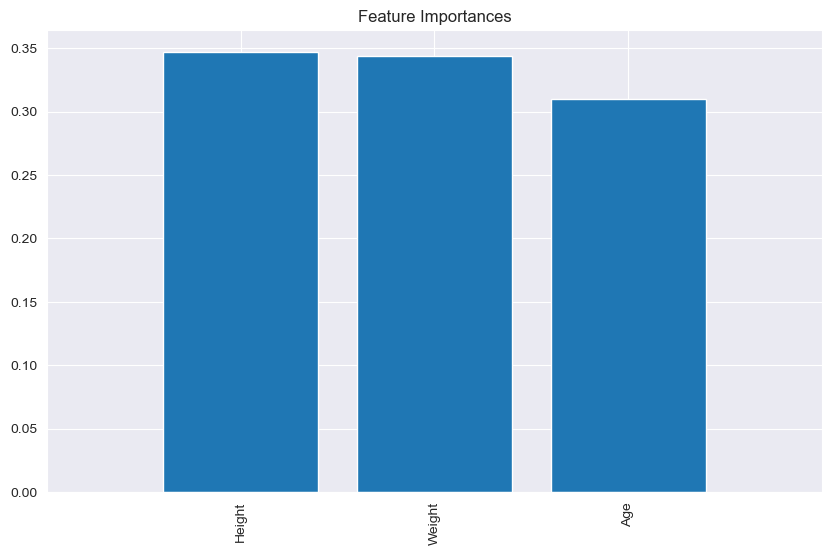

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       353
           1       0.89      0.70      0.78        57

    accuracy                           0.95       410
   macro avg       0.92      0.84      0.88       410
weighted avg       0.94      0.95      0.94       410



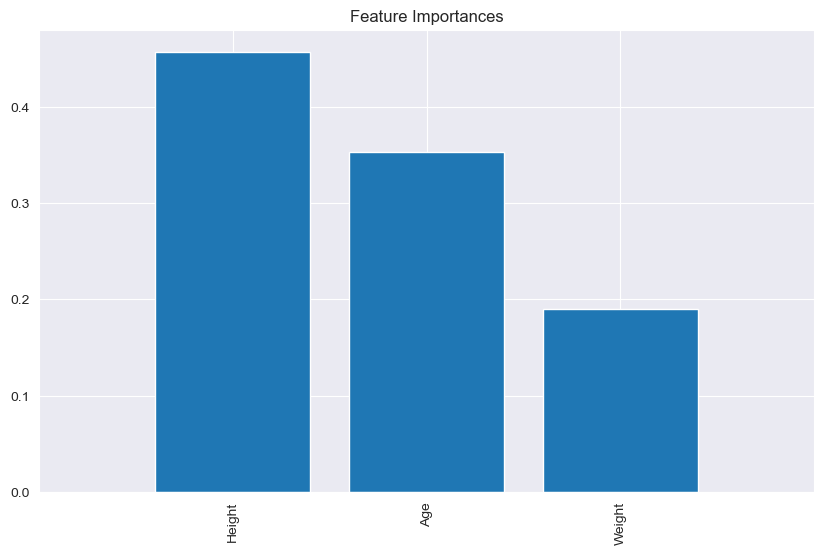

RandomForestClassifier()

In [54]:
random_forest_model(swimming_df, feature_cols=['Height', 'Weight', 'Age'], target_col='Medal')
random_forest_model(gymnastics_df, feature_cols=['Height', 'Weight', 'Age'], target_col='Medal')
random_forest_model(boxing_df, feature_cols=['Height', 'Weight', 'Age'], target_col='Medal')

Wow! Cool to see that Height has more importance than weight in gymnastics and boxing, but opposite in swimming, but both are very important nonethless. The classification report for boxing was also very promising, perhaps the model can pick out the small differences that lead to a medalist vs. non-medalist.

# Adding Geographic Influence into the Models
Here, in order to add Geographic influence we will one-hot encode the NOC data in the columns for the events.

In [47]:
# One-Hot Encode the 'NOC' column
one_swimming_df = pd.get_dummies(swimming_df, columns=['NOC'], drop_first=True)
one_gymnastics_df = pd.get_dummies(gymnastics_df, columns=['NOC'], drop_first=True)
one_boxing_df = pd.get_dummies(boxing_df, columns=['NOC'], drop_first=True)
one_swimming_df.head()

Sex   Age  Height  Weight  Year     Sport  \
244     0  26.0   170.0    70.0  2004  Swimming   
551     0  24.0   181.0    73.0  1968  Swimming   
751     0  20.0   180.0    74.0  2016  Swimming   
1022    0  19.0   177.0    64.0  1980  Swimming   
1344    0  22.0   190.0    80.0  2008  Swimming   

                                    Event  Medal  NOC_ALB  NOC_ALG  ...  \
244   Swimming Men's 100 metres Freestyle      0    False    False  ...   
551   Swimming Men's 100 metres Freestyle      0    False    False  ...   
751   Swimming Men's 100 metres Freestyle      0    False    False  ...   
1022  Swimming Men's 100 metres Freestyle      0    False    False  ...   
1344  Swimming Men's 100 metres Freestyle      0    False    False  ...   

      NOC_UKR  NOC_URS  NOC_URU  NOC_USA  NOC_UZB  NOC_VEN  NOC_VIE  NOC_VNM  \
244     False    False    False    False    False    False    False    False   
551     False    False    False    False    False    False    False    False   
751     False    False    False    False    False    False    False    False   
1022    False    False    False    False    False    False    False    False   
1344    False    False    False    False    False    False    False    False   

      NOC_YUG  NOC_ZIM  
244     False    False  
551     False    False  
751     False    False  
1022    False    False  
1344    False    False  

[5 rows x 147 columns]

### Logistic With Geographic
without Age

Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87       234
           1       0.23      0.71      0.35        21

    accuracy                           0.78       255
   macro avg       0.60      0.75      0.61       255
weighted avg       0.91      0.78      0.83       255



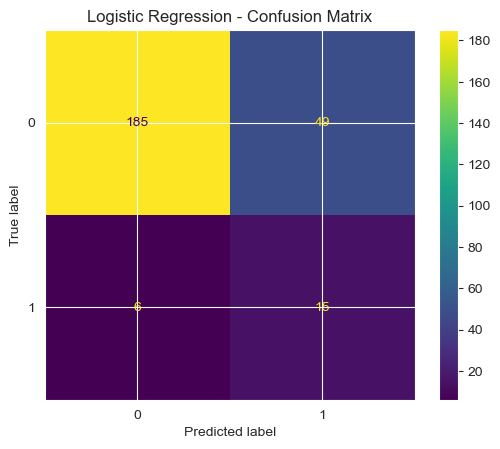

Cross-Validation Accuracy: 0.82 ± 0.07
Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86       399
           1       0.09      0.64      0.15        14

    accuracy                           0.76       413
   macro avg       0.54      0.70      0.51       413
weighted avg       0.95      0.76      0.84       413



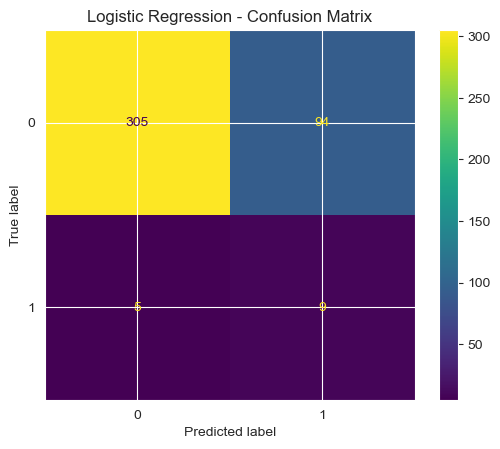

Cross-Validation Accuracy: 0.77 ± 0.02
Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.63      0.75       109
           1       0.15      0.50      0.23        14

    accuracy                           0.62       123
   macro avg       0.53      0.57      0.49       123
weighted avg       0.82      0.62      0.69       123



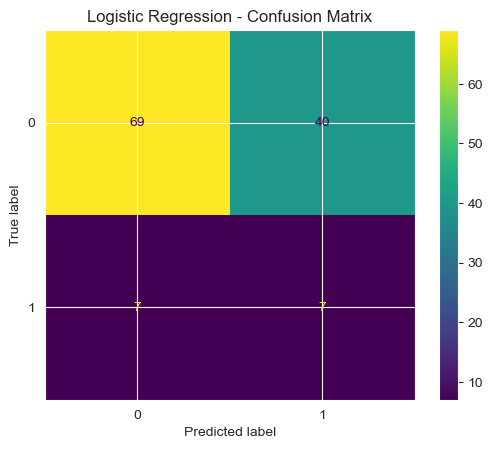

Cross-Validation Accuracy: 0.68 ± 0.05


In [56]:
feature_cols_swim = ['Height', 'Weight'] + [col for col in one_swimming_df.columns if col.startswith('NOC_')]
feature_cols_gym = ['Height', 'Weight'] + [col for col in one_gymnastics_df.columns if col.startswith('NOC_')]
feature_cols_box = ['Height', 'Weight'] + [col for col in one_boxing_df.columns if col.startswith('NOC_')]
logistic_regression_model(one_swimming_df, feature_cols_swim, target_col='Medal')
logistic_regression_model(one_gymnastics_df, feature_cols_gym, target_col='Medal')
logistic_regression_model(one_boxing_df, feature_cols_box, target_col='Medal')

### Logistic with Age

Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87       234
           1       0.23      0.71      0.35        21

    accuracy                           0.78       255
   macro avg       0.60      0.75      0.61       255
weighted avg       0.91      0.78      0.83       255



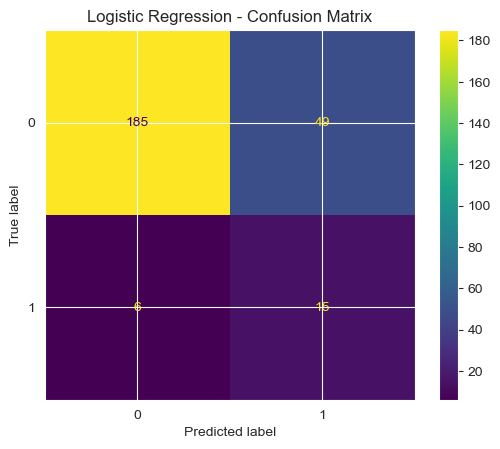

Cross-Validation Accuracy: 0.82 ± 0.08
Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85       399
           1       0.08      0.64      0.15        14

    accuracy                           0.75       413
   macro avg       0.53      0.70      0.50       413
weighted avg       0.95      0.75      0.83       413



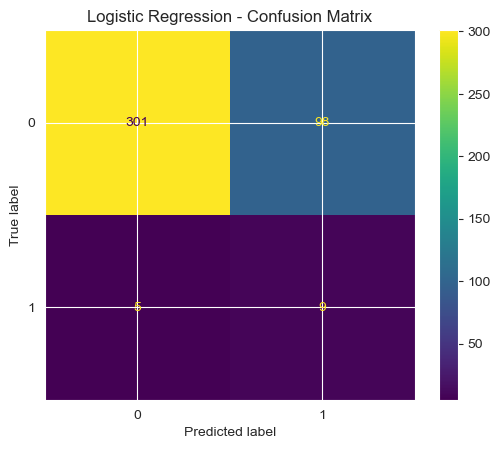

Cross-Validation Accuracy: 0.77 ± 0.02
Accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.69      0.79       109
           1       0.17      0.50      0.25        14

    accuracy                           0.67       123
   macro avg       0.54      0.59      0.52       123
weighted avg       0.83      0.67      0.72       123



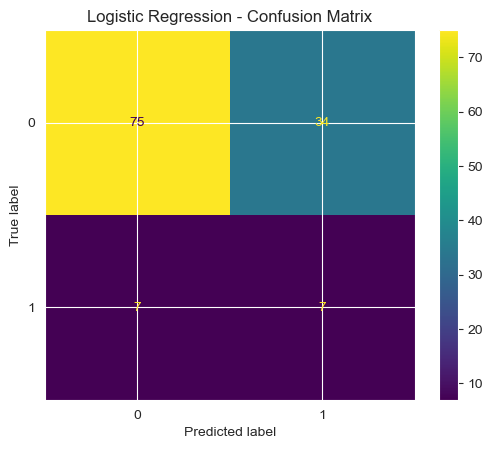

Cross-Validation Accuracy: 0.70 ± 0.05


In [57]:
age_feature_cols_swim = ['Height', 'Weight', 'Age'] + [col for col in one_swimming_df.columns if col.startswith('NOC_')]
age_feature_cols_gym = ['Height', 'Weight', 'Age'] + [col for col in one_gymnastics_df.columns if col.startswith('NOC_')]
age_feature_cols_box = ['Height', 'Weight', 'Age'] + [col for col in one_boxing_df.columns if col.startswith('NOC_')]
logistic_regression_model(one_swimming_df, age_feature_cols_swim, target_col='Medal')
logistic_regression_model(one_gymnastics_df, age_feature_cols_gym, target_col='Medal')
logistic_regression_model(one_boxing_df, age_feature_cols_box, target_col='Medal')

Pretty solid results, swimming's accuracy has improved substainitially, same with the other sports

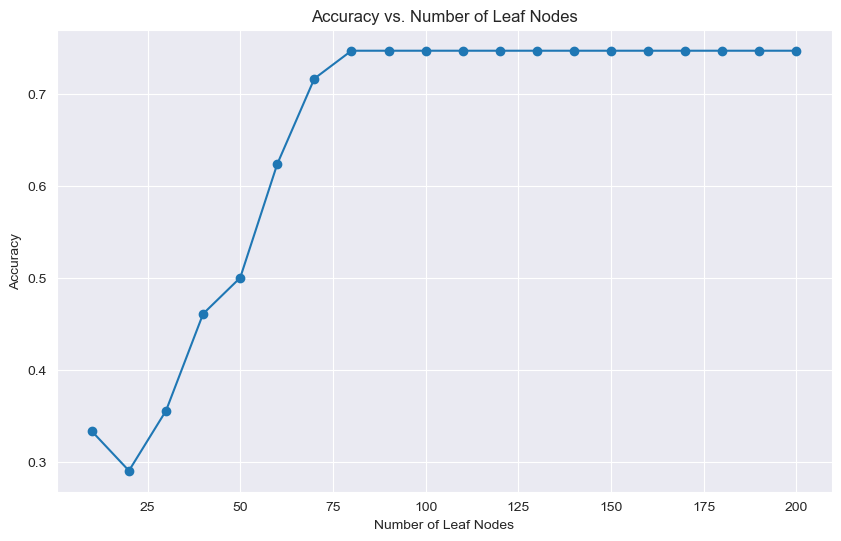

Best Number of Leaf Nodes: 80
Best Precision Score: 0.7464788732394366
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       797
           1       0.75      1.00      0.85        53

    accuracy                           0.98       850
   macro avg       0.87      0.99      0.92       850
weighted avg       0.98      0.98      0.98       850



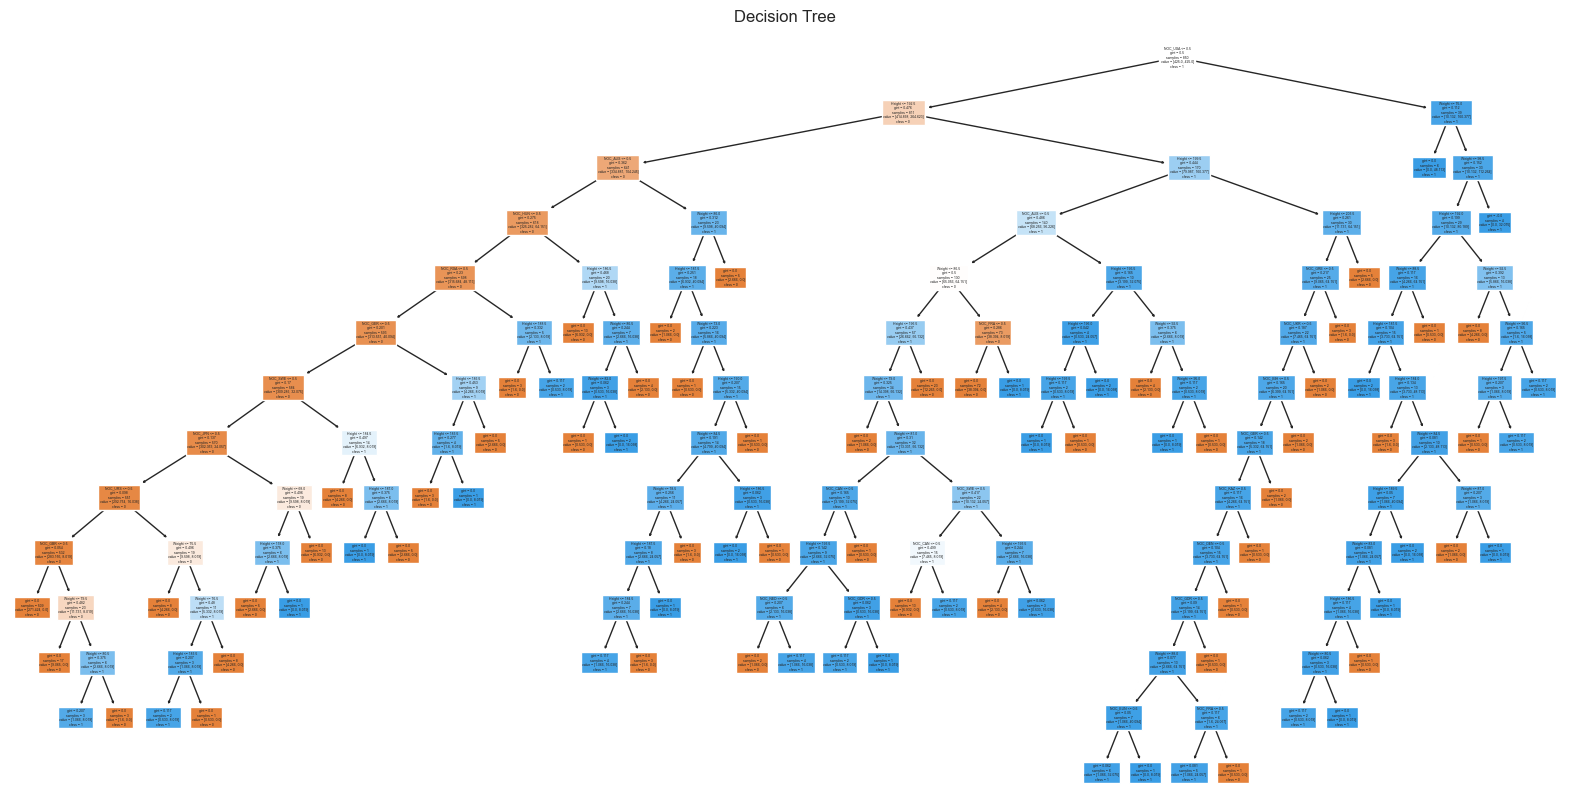

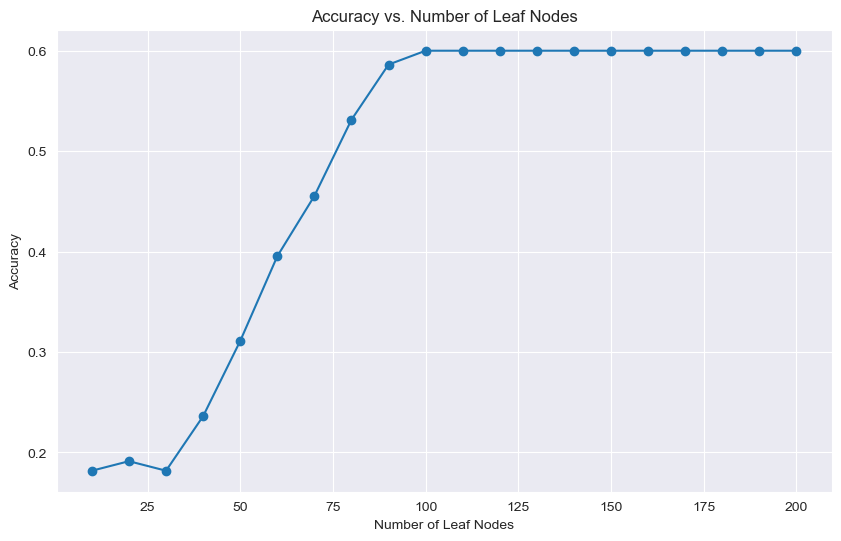

Best Number of Leaf Nodes: 100
Best Precision Score: 0.6
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1325
           1       0.60      1.00      0.75        51

    accuracy                           0.98      1376
   macro avg       0.80      0.99      0.87      1376
weighted avg       0.99      0.98      0.98      1376



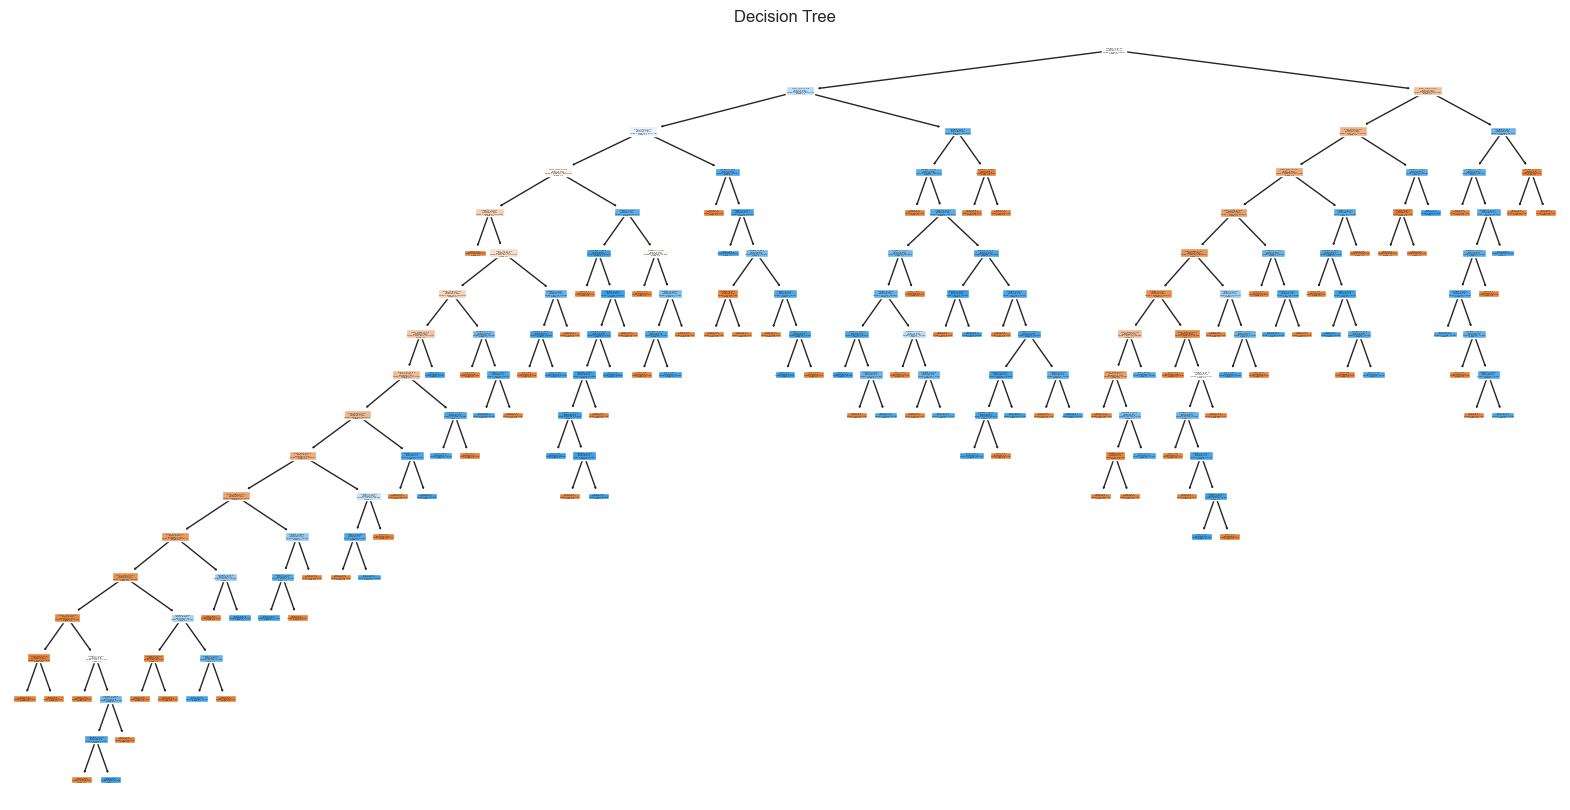

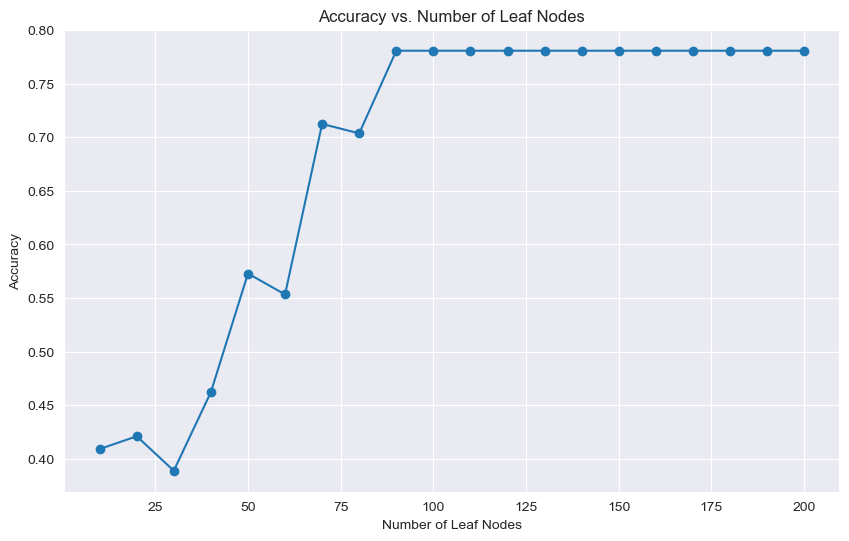

Best Number of Leaf Nodes: 90
Best Precision Score: 0.7808219178082192
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       353
           1       0.77      1.00      0.87        57

    accuracy                           0.96       410
   macro avg       0.89      0.98      0.92       410
weighted avg       0.97      0.96      0.96       410



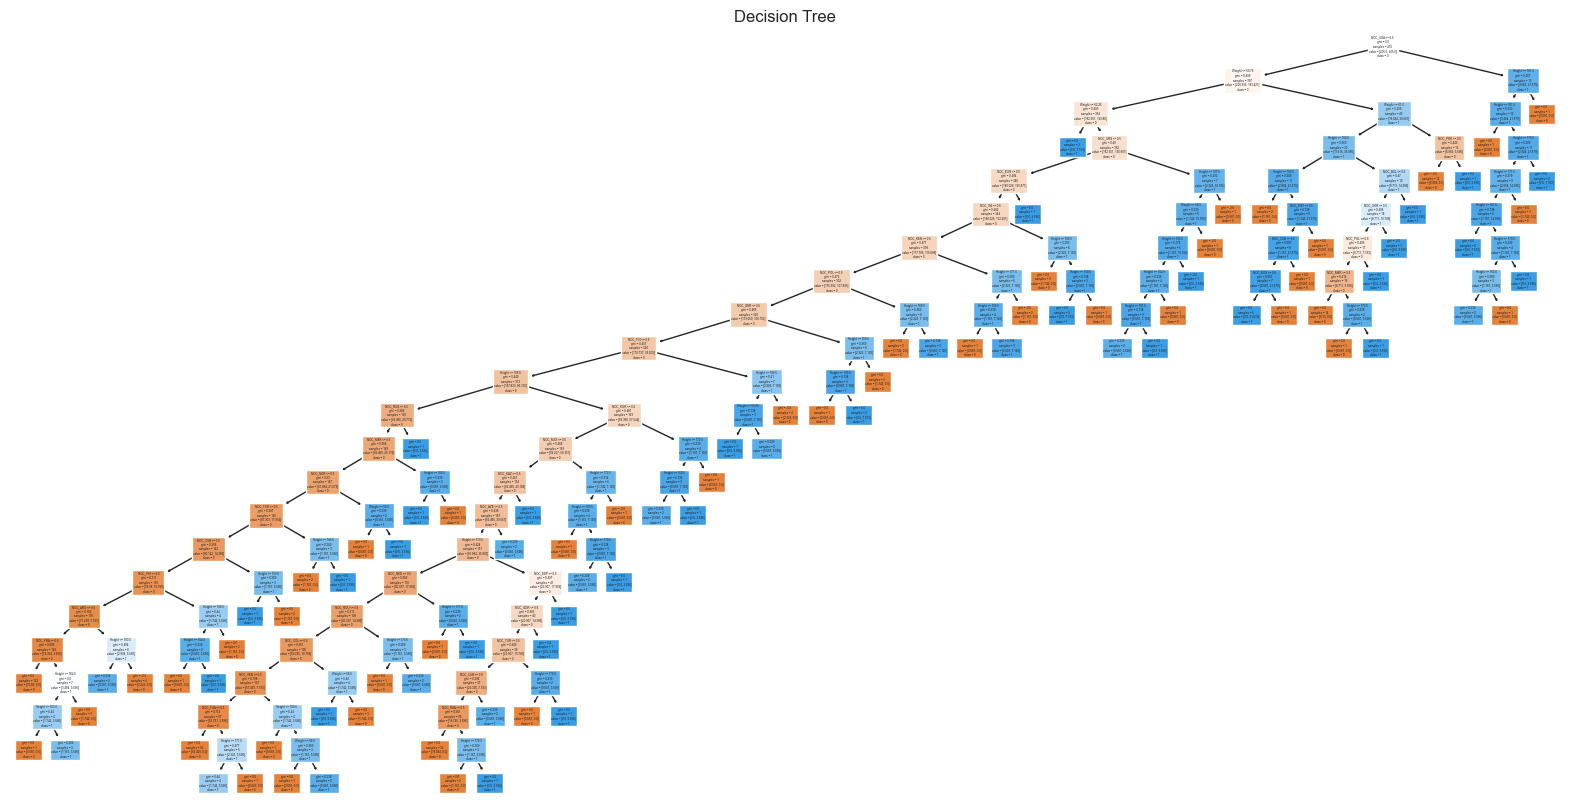

In [58]:
one_dtc = decision_tree_model(one_swimming_df, feature_cols=feature_cols_swim, target_col='Medal')
one_dtc2 = decision_tree_model(one_gymnastics_df, feature_cols=feature_cols_gym, target_col='Medal')
one_dtc3 = decision_tree_model(one_boxing_df, feature_cols=feature_cols_box, target_col='Medal')

### Decision Tree with Age
Trying a decision tree with Age as a factor, no geographic

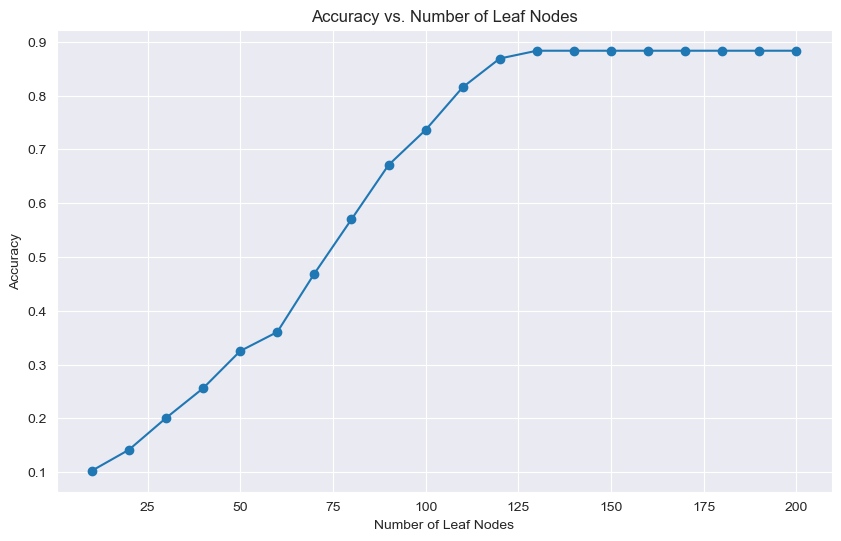

Best Number of Leaf Nodes: 130
Best Precision Score: 0.8833333333333333
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       797
           1       0.88      1.00      0.94        53

    accuracy                           0.99       850
   macro avg       0.94      1.00      0.97       850
weighted avg       0.99      0.99      0.99       850



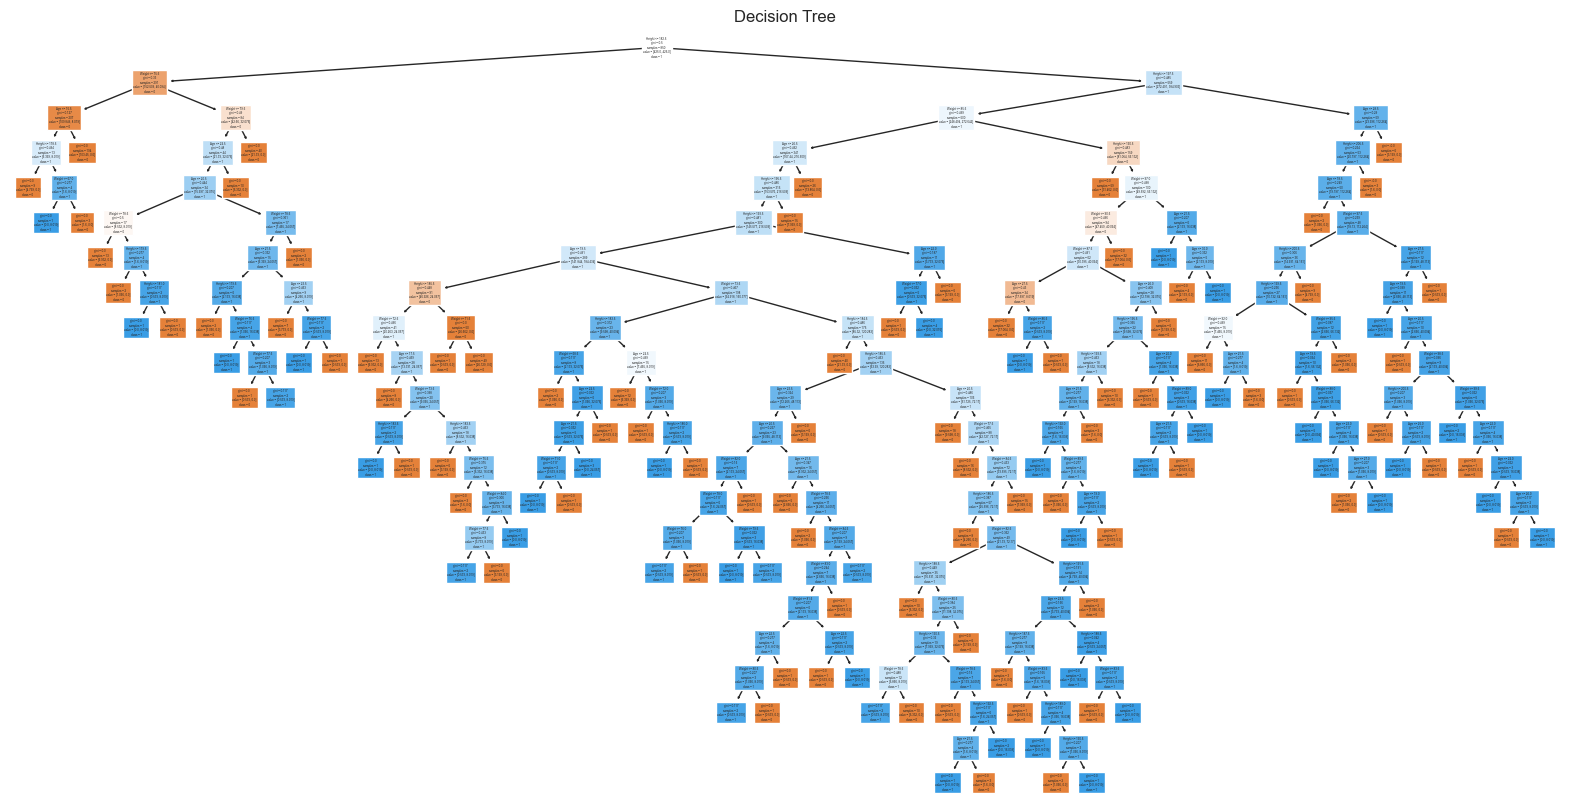

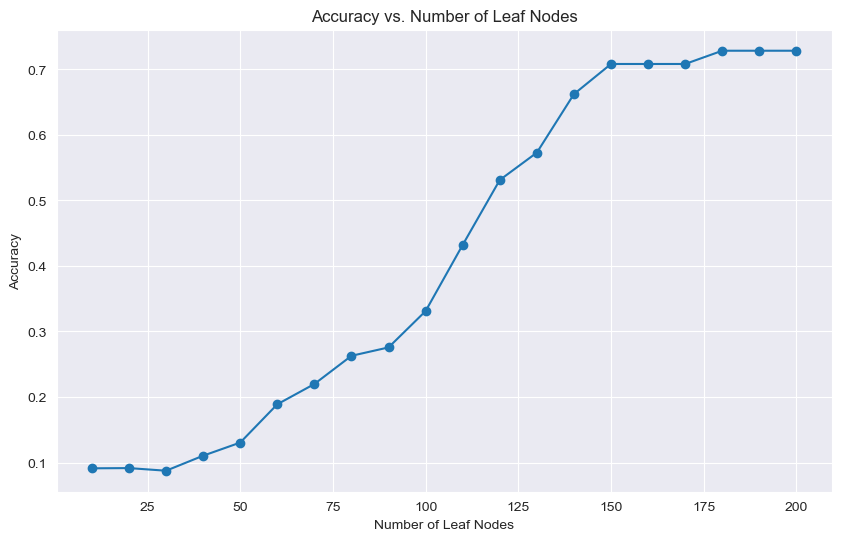

Best Number of Leaf Nodes: 180
Best Precision Score: 0.7285714285714285
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1325
           1       0.71      1.00      0.83        51

    accuracy                           0.98      1376
   macro avg       0.85      0.99      0.91      1376
weighted avg       0.99      0.98      0.99      1376



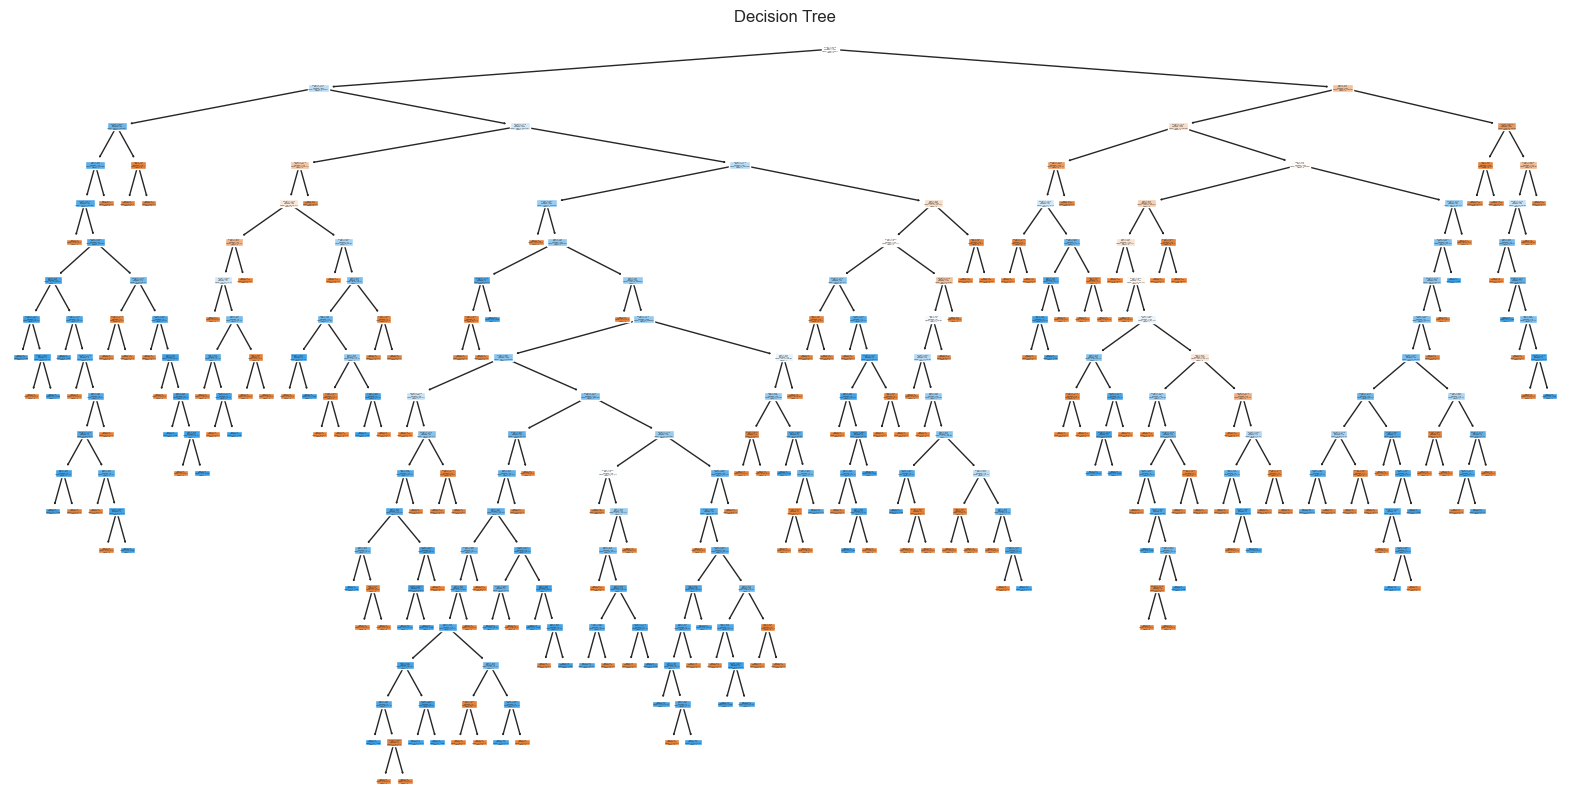

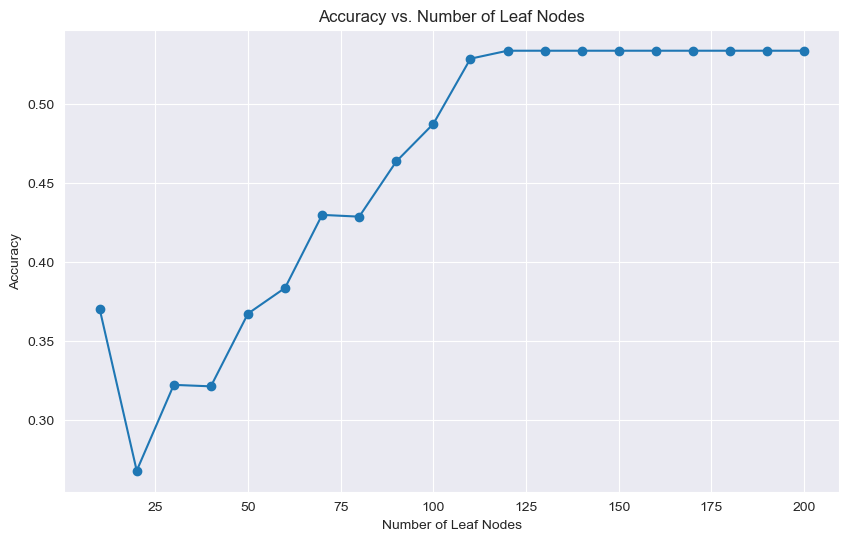

Best Number of Leaf Nodes: 120
Best Precision Score: 0.5333333333333333
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       353
           1       0.53      0.98      0.69        57

    accuracy                           0.88       410
   macro avg       0.77      0.92      0.81       410
weighted avg       0.93      0.88      0.89       410



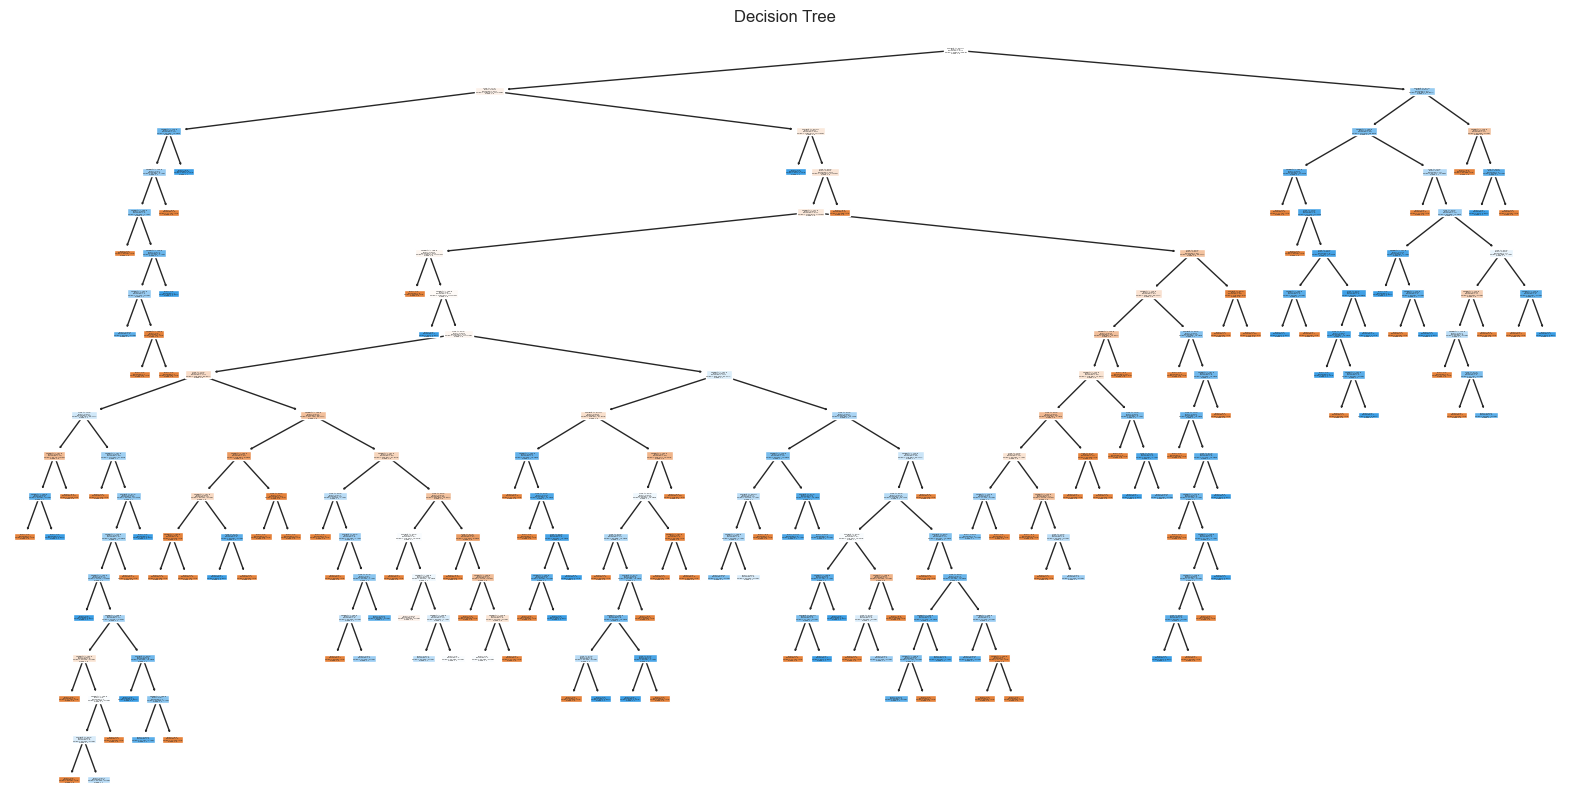

In [50]:
age_dtc = decision_tree_model(swimming_df, feature_cols=['Height', 'Weight', 'Age'], target_col='Medal')
age_dtc2 = decision_tree_model(gymnastics_df, feature_cols=['Height', 'Weight', 'Age'], target_col='Medal')
age_dtc3 = decision_tree_model(boxing_df, feature_cols=['Height', 'Weight', 'Age'], target_col='Medal')

### SVM with Geographic

Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.68      0.80       234
           1       0.16      0.67      0.26        21

    accuracy                           0.68       255
   macro avg       0.56      0.68      0.53       255
weighted avg       0.89      0.68      0.75       255



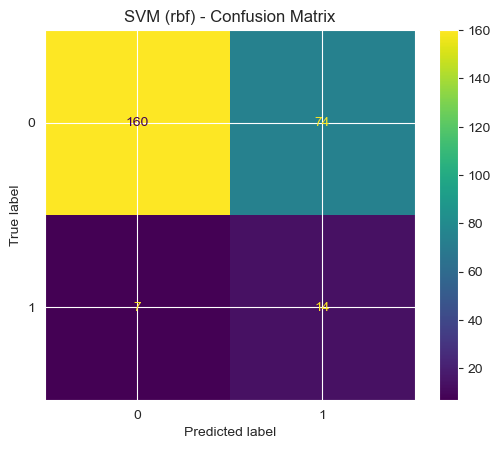

Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86       399
           1       0.09      0.64      0.15        14

    accuracy                           0.76       413
   macro avg       0.54      0.70      0.51       413
weighted avg       0.95      0.76      0.83       413



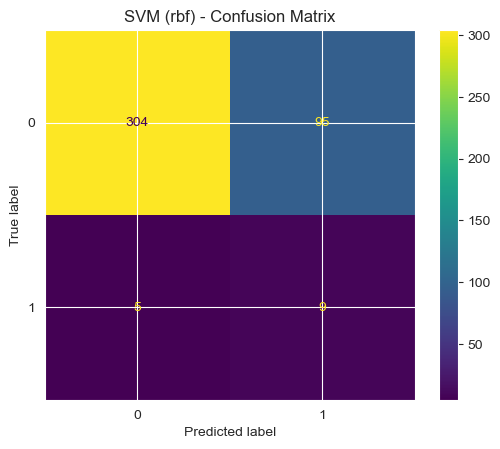

Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.54      0.68       109
           1       0.14      0.57      0.22        14

    accuracy                           0.54       123
   macro avg       0.52      0.56      0.45       123
weighted avg       0.82      0.54      0.63       123



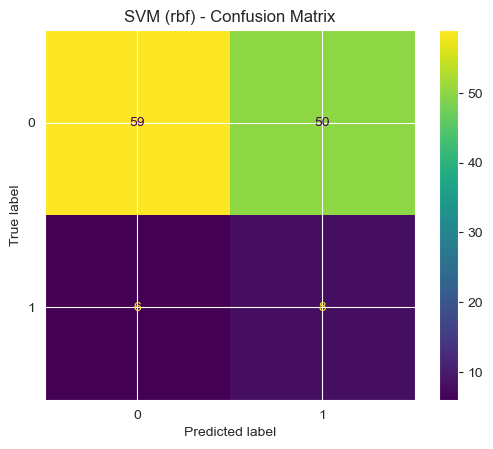

In [59]:
## Calling the SVM
svm_model(one_swimming_df, feature_cols=feature_cols_swim, target_col='Medal', kernel='rbf')
svm_model(one_gymnastics_df, feature_cols=feature_cols_gym, target_col='Medal', kernel='rbf')
svm_model(one_boxing_df, feature_cols=feature_cols_box, target_col='Medal', kernel='rbf')

Key idea here is that when geographic data is added to sports where diff between medalists and non-medalists attributes is large, then the SVM's accuracy increases. However, for events such as Boxing, the SVM's decreases, suggesting that it is harmful for events where difference between medalists and non-medalists is not substantial. 